# next up
1. calculate K values in non-Monte carlo matrix
2. use these values to set up monte carlo arrays of k values
3. feed these monte carlo arrays into flux function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyval
from gsw import pt_from_CT,SP_from_SA,CT_from_pt,rho
from gasex._utilities import match_args_return
from gasex.phys import K0 as K0
from gasex.phys import RatmLmolK
from gasex.phys import vpress_sw, vpress_w, R, cdlp81, atm2pa, visc
from gasex.sol import *
from gasex.diff import diff, schmidt, schmidt_W14
from metpy.calc import density # use metpy to calculate air density
from metpy.units import units
from metpy.calc import mixing_ratio_from_relative_humidity # calculate mixing ratio of water vapor in air
import xarray as xr
import gsw as gsw
from scipy.interpolate import RegularGridInterpolator # use for 2D interpolation of gridded ERA5 data to scattered argo data
#from tqdm import tqdm # progress bar - use this version for a python script
from tqdm.notebook import tqdm # this version for a notebook
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#from gasex.sol import air_mol_fract
from gasex.sol import sol_SP_pt
from gasex.sol import CO2sol_SP_pt

In [3]:
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [4]:
s04 = pd.read_csv('n2otests/s04.csv')
s04.columns

Index(['Unnamed: 0', 'LONGITUDE', 'LATITUDE', 'YEAR', 'EXPOCODE', 'woce_lines',
       'startDate', 'endDate', 'source', 'SECT_ID', 'STNNBR', 'CASTNO',
       'BTLNBR', 'SAMPNO', 'DATE', 'TIME', 'DEPTH', 'CTDPRS', 'CTDPRS_FLAG_W',
       'CTDTMP', 'CTDTMP_FLAG_W', 'CTDSAL', 'CTDSAL_FLAG_W', 'SALNTY',
       'SALNTY_FLAG_W', 'CTDOXY', 'CTDOXY_FLAG_W', 'NITRAT', 'NITRAT_FLAG_W',
       'N2O', 'N2O_FLAG_W', 'SA', 'PT', 'CT', 'rho', 'sigma0', 'O2sat',
       'spiciness', 'AOU', 'N2O_nM', 'N2Osol', 'pN2O', 'DN2O', 'BIOME_NUM',
       'BIOME_ABREV', 'BIOME_FULL'],
      dtype='object')

In [5]:
# test air_mol_fract
from gasex.sol import air_mol_fract
air_mol_fract(gas="N2O")

ValueError: must specify chi_atm for N2O. Default chi_atm only available for O2, He, Ne, Ar, Kr, Xe, and N2.

In [ ]:
def air_mol_fract(gas=None):
    """molar mixing ratio for well-mixed gases

    Args:
        gas ([string], optional): abbreviation for gas. Defaults to None.

    Raises:
        ValueError: [description]

    Returns:
        xG: molar atmospheric mixing ratio for well-lixed gases ('O2','HE','NE','AR','KR','XE' or 'N2')
    """
    g_up = gas.upper()
    if g_up in ['O2','HE','NE','AR','KR','XE','N2']:
        frac_dict = {'O2':np.array([0.209790]), \
                 'HE':np.array([5.24e-6]), \
                 'NE':np.array([0.00001818]), \
                 'AR':np.array([0.009332]), \
                 'KR':np.array([0.00000114]), \
                 'XE':np.array([8.7e-8]), \
                 'N2':np.array([0.780848]) }
        return frac_dict[g_up]
    else:
        raise ValueError(f"must specify chi_atm for {g_up}. Default chi_atm only available for O2, He, Ne, Ar, Kr, Xe, and N2.") 

In [6]:
air_mol_fract(gas="N2O")

ValueError: must specify chi_atm for N2O. Default chi_atm only available for O2, He, Ne, Ar, Kr, Xe, and N2.

In [7]:
@match_args_return
def N2Ofugacity_factor(pt,slp=1.0):
    """
    Calculate the fugacity of N2O in seawater.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: Mixing ratio of N2O  in dry air (ppb) (default: 333 ppb)
    - units: Units of fugacity ("natm" for nanonatmospheres, "atm" for atmospheres) (default: "natm")

    Returns:
    - f: Fugacity of N2O in the specified units
    """
    # Weiss and Price calculation uses R = 0.08205601 L*atm/mol/K
    # define local R here instead of using global R from gasex.phys
    R = 0.08205601

    # Weiss and Price: partial molal volume of N2O is 32.2 cm3/mol
    v=32.3
    # need to convert from cm3 to L for exponential term 2 to be dimensionless
    v = v/1000

    # Convert temperature to IPTS-68 to match temperatures used in Weiss and Price
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # Calculate exponential term 1 (Weiss and Price )1980, eqn. (11))
    eterm1 = slp*(-9.4563/y + 0.04739 - 6.427*10**-5*y)
    
    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)
    
    # fugacity, Weiss and Price 1980, eqn. (7)
    fugfac = np.exp(eterm1+eterm2)

    return fugfac

print(N2Ofugacity_factor(0,slp=1))

0.9952266385057084


In [8]:
# check to make sure gasex.fugacity returns the same thing
from gasex.fugacity import N2Ofugacity_factor
N2Ofugacity_factor(0,slp=1)

0.9952266385057084

In [9]:
def CO2fugacity_factor(
    pt,
    opt_k_carbonic,
    gas_constant,
    pressure_bar,
    pressure_atmosphere=1.0,
    opt_pressured_kCO2=0,
):
    """
    Function from PyCO2SYS
    Calculate the fugacity factor following W74.

    Parameters
    ----------
    temperature : float
        Temperature in °C.
    opt_k_carbonic : int
        Which carbonic acid dissociation constants to use.
    gas_constant : float
        The universal gas constant in .
    pressure_bar : float
        Hydrostatic pressure in bar.
    pressure_atmosphere : float, optional
        Atmospheric pressure in atm, by default 1.0.
    opt_pressured_kCO2 : int, optional
        Whether to include the hydrostatic pressure effect, by default 0 (i.e., no).

    Returns
    -------
    float
        The fugacity factor; multiply this by pCO2 to get fCO2.
    """
    # Unless opt_pressured_kCO2 is set to 1, this assumes that the pressure is at one
    # atmosphere, or close to it.
    # Otherwise, the pressure term in the exponent affects the results.
    # Following Weiss, R. F., Marine Chemistry 2:203-215, 1974.
    # Delta and B are in cm**3/mol.
    TempK = pt + K0
    RT = gas_constant * TempK
    Delta = 57.7 - 0.118 * TempK
    b = (
        -1636.75
        + 12.0408 * TempK
        - 0.0327957 * TempK**2
        + 3.16528 * 0.00001 * TempK**3
    )
    # # For a mixture of CO2 and air at 1 atm (at low CO2 concentrations):
    # P1atm = 1.01325  # in bar
    p_bar = pressure_atmosphere * 1.01325  # convert atm to bar
    # If requested (opt_pressured_kCO2 == 1), account for hydrostatic pressure (new in
    # v1.8.2) - otherwise, just use atmospheric pressure like in previous versions
    p_total = np.where(opt_pressured_kCO2 == 1, p_bar + pressure_bar, p_bar)
    # Note that the x2**2 term below is ignored because it is almost equal to 1
    # (x2 = (1 - xCO2); xCO2 << 1)
    FugFac = np.exp((b + 2 * Delta) * p_total / RT)
    # GEOSECS and Peng assume pCO2 = fCO2, or FugFac = 1
    FugFac = np.where(np.isin(opt_k_carbonic, [6, 7]), 1.0, FugFac)
    return FugFac

In [10]:
@match_args_return
def fugacity_factor(pt,gas=None,slp=1.0):
    g_up = gas.upper()

    if g_up == 'CO2':
        #fugfac = CO2fugacity_factor(pt,slp=slp)
        return 1
    elif g_up == 'N2O':
        return N2Ofugacity_factor(pt,slp=slp)
    else:
        return 1
print(fugacity_factor(20,gas="N2O", slp=1))

0.9962987882776103


In [11]:
# check to make sure gasex.fugacity returns the same thing
from gasex.fugacity import fugacity_factor
fugacity_factor(0,gas="N2O", slp=1)

0.9952266385057084

In [12]:
@match_args_return
def eq_SP_pt(SP,pt,*,gas=None,slp=1.0,units="mM",chi_atm=None):
    """
    Description:
    -----------
    Wrapper function to calculate equilibrium solubility in [mol L-1] for gases
    with constant atmospheric mixing ratios.  Nobles gases, N2 and O2 are
    included.

    INPUT:
    -----------
    REQUIRED:
      SP  =  Practical Salinity  (PSS-78)                         [ unitless ]
      pt  =  potential temperature (ITS-90) referenced               [ deg C ]
             to one standard atmosphere (0 dbar).
      gas =  String abbreviation for gas (He,Ne,Ar,Kr,Xe,O2 or N2)
    OPTIONAL:
      patm = total atmospheric pressure in atm (default = 1.0 atm)
      units = output units "M" or "umolkg" (default = M)

    OUTPUT:
    -----------
         soleq = gas eq. solubility including moist atmosphere             [M]

    AUTHOR: David Nicholson
    -----------
    """
    g_up = gas.upper()
    vp_sw = vpress_sw(SP,pt)
    SA = SP * 35.16504/35
    CT = CT_from_pt(SA,pt)
    dens = rho(SA,CT,0*CT)

    if chi_atm is None:
        chi_atm = air_mol_fract(gas=gas)
    
    if slp != 1.0:
        p_corr = (slp - vp_sw) / (1 - vp_sw)
    else:
         p_corr = 1
    
    f  = fugacity_factor(pt,gas=gas,slp=slp)

    if gas == 'O2':
        soleq = O2sol_SP_pt(SP,pt)
    elif gas == 'He':
        soleq = Hesol_SP_pt(SP,pt)
    elif gas == 'Ne':
        soleq = Nesol_SP_pt(SP,pt)
    elif gas == 'Ar':
        soleq = Arsol_SP_pt(SP,pt)
    elif gas == 'Kr':
        soleq = Krsol_SP_pt(SP,pt)
    elif gas == 'Xe':
        soleq = Xesol_SP_pt(SP,pt)
    elif gas == 'N2':
        soleq = N2sol_SP_pt(SP,pt)
    elif gas == 'N2O':
        k = N2Osol_SP_pt(SP,pt)
        soleq = k*chi_atm*(1 - vp_sw) # mol/L
        soleq = soleq/dens*1000*1e6 # convert to umol/kg
    elif gas == 'CO2':
        k = CO2sol_SP_pt(SP,pt)
        soleq = k*chi_atm*(1 - vp_sw) # mol/L
        soleq = soleq/dens*1000*1e6 # convert to umol/kg
    elif gas == 'CH4':
        k = CH4sol_SP_pt(SP,pt)
        soleq = k*chi_atm*(1 - vp_sw) # mol/L
        soleq = soleq/dens*1000*1e6 # convert to umol/kg
    else:
        raise ValueError(gas + " is supported. Must be O2,He,Ne,Ar,Kr,Xe or \
                         N2")
    if units not in ("M","mM","uM","nM","molm3","umolkg"):
        raise ValueError("units: units must be \'M\','uM' or \'umolkg\'")

    soleq = soleq*f # apply fugacity factor
    
    if units == "M":
        eq =  p_corr * dens * soleq / 1e9
    elif units =="mM" or units =="molm3":
        eq =  p_corr * dens * soleq / 1e6
    elif units =="uM":
        eq =  p_corr * dens * soleq / 1e3
    elif units == "nM":
        eq =  p_corr * dens * soleq
    elif units == 'umolkg':
        eq =  p_corr * soleq
    return eq
print(eq_SP_pt(33,0,gas="N2O",slp=1.0,chi_atm=338e-9, units = "nM"))

16.2553618399974


In [13]:
# test to make sure gasex.sol returns the same thing
from gasex.sol import eq_SP_pt
eq_SP_pt(33,0,gas="N2O",slp=1.0,chi_atm=338e-9, units = "nM")

16.2553618399974

In [14]:
@match_args_return
def N2Ofugacity(SP,pt,slp=1.0,xn2o=338e-9,v=32.3,rh=1.0,units = "natm"):
    """
    Calculate the fugacity of N2O in seawater.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: Mixing ratio of N2O  in dry air (ppb) (default: 333 ppb)
    - units: Units of fugacity ("natm" for nanonatmospheres, "atm" for atmospheres) (default: "natm")

    Returns:
    - f: Fugacity of N2O in the specified units
    """
    # calculate fugacity factor
    fugfac = N2Ofugacity_factor(pt,slp=slp)

    # convert xn2o from mol/mol to ppb
    xn2o = xn2o*1e9
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)*rh # vapor pressure of water
    
    # fugacity, Weiss and Price 1980, eqn. (7)
    f = xn2o*(slp-vp_sw)*fugfac
    
    # Convert to atmospheres if specified
    if units.lower() == "atm":
        f = f*10**-9

    return f

print(N2Ofugacity(33,0, slp=0.94))

314.3273037347299


In [15]:
from gasex.fugacity import N2Ofugacity
N2Ofugacity(33,0, slp=0.94)

314.3273037347299

In [16]:
def N2OCeq(SP, pt, slp=1.0, xn2o=338e-9, watervapor=True, rh=1.0, nonideal=True, units="nM"):
    """
    Calculate the equilibrium concentration of N2O in seawater,
    taking into account the vapor pressure of water and non-ideal effects.

    Parameters:
    - SP: Practical Salinity (PSS-78) (unitless)
    - pt: Potential temperature (ITS-90) referenced to one standard atmosphere (0 dbar) (°C)
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: Mixing ratio of N2O  in dry air (mol/mol) (default: 338e-9)
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - Ceq: Equilibrium concentration of N2O in specified  (default: nM)
    """   
   
    # Calculate fugacity factor
    fugfac = N2Ofugacity_factor(pt,slp=slp)
    
    # Calculate equilibrium constant, mol/L/atm
    s = N2Osol_SP_pt(SP,pt)
    
    # convert xn2o from mol/mol to ppb
    xn2o = xn2o*1e9
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)*rh

    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    if (watervapor==True)&(nonideal==True):
        # Weiss and Price 1980, eqn. (8)
        Ceq = s*xn2o*(slp - vp_sw)*fugfac
    elif (watervapor==True)&(nonideal==False):
        # exclude non-ideal effects
        Ceq = s*xn2o*(slp - vp_sw)
    elif (watervapor==False)&(nonideal==False):
        # exclude vapor pressure of water and non-ideal effects
        Ceq = s*xn2o*slp
    elif (watervapor==False)&(nonideal==True):
        Ceq = xn2o*s*slp*fugfac
    
    if units=='umolkg':
        SA = SP * 35.16504/35
        CT = CT_from_pt(SA,pt)
        dens = rho(SA,CT,0*CT)
        Ceq = Ceq / dens
    
    return Ceq

In [17]:
N2OCeq(33,0)

16.255361839997402

In [18]:
N2OCeq(33,20)

7.965197803749233

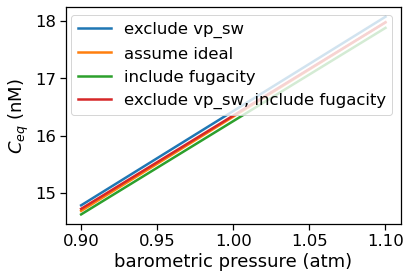

In [26]:
slps = np.linspace(0.9,1.1)
cs1 = []
cs2 = []
cs3 = []
cs4 = []
for slp in slps:
    Ceq1 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=True)
    Ceq2 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=False)
    Ceq3 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=False, nonideal=False)
    Ceq4 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=False, nonideal=True)
    cs1.append(Ceq1)
    cs2.append(Ceq2)
    cs3.append(Ceq3)
    cs4.append(Ceq4)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(cs3), label = "exclude vp_sw")
ax.plot(slps, np.array(cs2), label = "assume ideal")
ax.plot(slps, np.array(cs1), label = "include fugacity")
ax.plot(slps, np.array(cs4), label = "exclude vp_sw, include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$C_{eq}$ (nM)")
plt.show()

Text(0.5, 0, 'potential temperature ($\\degree C$)')

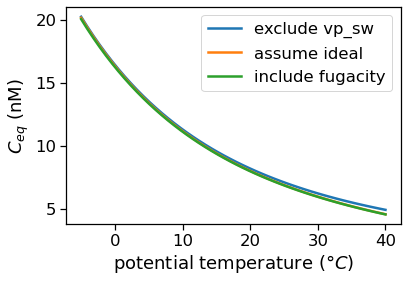

In [27]:
temps = np.linspace(-5,40)
cs1 = []
cs2 = []
cs3 = []
cdiff = []
for t in temps:
    Ceq1 = N2OCeq(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=True)
    Ceq2 = N2OCeq(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=False)
    Ceq3 = N2OCeq(33, t, slp = 1.0, xn2o=338e-9, watervapor=False, nonideal=False)
    cs1.append(Ceq1)
    cs2.append(Ceq2)
    cs3.append(Ceq3)
    cdiff.append(Ceq2 - Ceq1)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(cs3), label = "exclude vp_sw")
ax.plot(temps, np.array(cs2), label = "assume ideal")
ax.plot(temps, np.array(cs1), label = "include fugacity")
ax.legend()
ax.set_ylabel("$C_{eq}$ (nM)")
ax.set_xlabel("potential temperature ($\degree C$)")

In [19]:
def pN2Osw(SP,pt,C, units = "natm"):
    """
    Calculate the fugacity of N2O in seawater.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - C: concentration (nmol/L)

    Returns:
    - pN2Osw: partial pressure of dissolved N2O (natm or atm)
    """    
    
    # Calculate equilibrium constant, mol/L/atm
    s = N2Osol_SP_pt(SP,pt)
    
    # calculate partial pressure of N2O in seawater (natm)
    pN2Osw = C/s
    
    # Convert to atmospheres if specified
    if units.lower() == "atm":
        pN2Osw = pN2Osw*10**-9

    return pN2Osw

In [20]:
def xN2Osw(SP, pt, C, slp=1.0, v=32.3, watervapor=True, nonideal=True):
    """
    Calculate the mixing ratio of N2O corresponding to a given concentration in seawater.

    Parameters:
    - SP: Practical Salinity (PSS-78) (unitless)
    - pt: Potential temperature (ITS-90) referenced to one standard atmosphere (0 dbar) (°C)
    - C: Concentration of N2O (nmol/L)
    - slp: Sea level pressure (atm) (default: 1.0)
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - s: Equilibrium constant (mol/L/atm)
    - F: Simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1)) (mol/L)
    - xN2O1: Mixing ratio of N2O (nmol/mol or ppb), including vapor pressure of water and non-ideal effects
    - xN2O2: Mixing ratio of N2O (nmol/mol or ppb), including vapor pressure of water and but excluding non-ideal effects
    - xN2O3: Mixing ratio of N2O (nmol/mol or ppb), excluding vapor pressure of water and non-ideal effects
    """  
   
    # Calculate fugacity factor
    fugfac = N2Ofugacity_factor(pt,slp=slp)
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)

    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # Calculate equilibrium constant, mol/L/atm
    s = N2Osol_SP_pt(SP,pt)

    if (watervapor==True)&(nonideal==True):
        # Weiss and Price 1980, eqn. (8)
        xN2O = C/(s*(slp-vp_sw)*fugfac)
    elif (watervapor==True)&(nonideal==False):
        # exclude non-ideal effects
        xN2O = C/(s*(slp - vp_sw))
    elif (watervapor==False)&(nonideal==False):
        # exclude vapor pressure of water and non-ideal effects
        xN2O = C/(s*slp)
    elif (watervapor==False)&(nonideal==True):
        xN2O = C/(s*(slp)*fugfac)
  
    return xN2O

In [21]:
xN2Osw(33, 0, 25, slp=1.0)

519.8284777154705

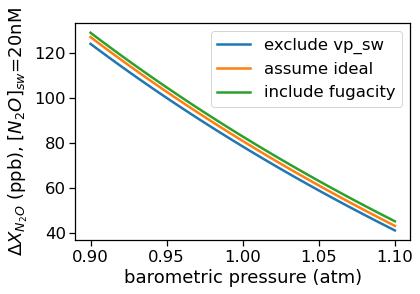

In [22]:
slps = np.linspace(0.9,1.1)
x1 = []
x2 = []
x3 = []
for slp in slps:
    xN2O1 = xN2Osw(33, 0, 20, slp = slp, watervapor=True, nonideal=True)
    xN2O2 = xN2Osw(33, 0, 20, slp = slp, watervapor=True, nonideal=False)
    xN2O3 = xN2Osw(33, 0, 20, slp = slp, watervapor=False, nonideal=False)
    x1.append(xN2O1)
    x2.append(xN2O2)
    x3.append(xN2O3)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(x3)-333, label = "exclude vp_sw")
ax.plot(slps, np.array(x2)-333, label = "assume ideal")
ax.plot(slps, np.array(x1)-333, label = "include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$\Delta X_{N_2O}$ (ppb), $[N_2O]_{sw}$=20nM")
plt.show()

Text(0.5, 0, 'potential temperature ($\\degree C$)')

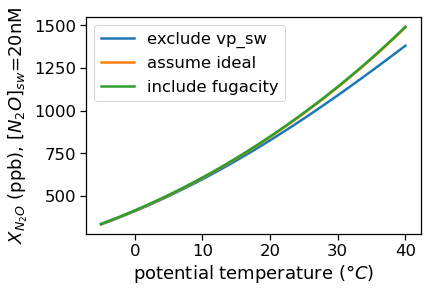

In [23]:
temps = np.linspace(-5,40)
x1 = []
x2 = []
x3 = []
for t in temps:
    xN2O1 = xN2Osw(33, t, 20, slp = 1.0, watervapor=True, nonideal=True)
    xN2O2 = xN2Osw(33, t, 20, slp = 1.0, watervapor=True, nonideal=False)
    xN2O3 = xN2Osw(33, t, 20, slp = 1.0, watervapor=False, nonideal=False)
    x1.append(xN2O1)
    x2.append(xN2O2)
    x3.append(xN2O3)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(x3), label = "exclude vp_sw")
ax.plot(temps, np.array(x2), label = "assume ideal")
ax.plot(temps, np.array(x1), label = "include fugacity")
ax.legend()
ax.set_ylabel("$X_{N_2O}$ (ppb), $[N_2O]_{sw}$=20nM")
ax.set_xlabel("potential temperature ($\degree C$)")

In [24]:
def calculate_air_density(temp_c, pressure_atm, mixing_ratio_g_kg):
    # Constants
    R_d = 287.058  # J/(kg·K) for dry air
    R_v = 461.495  # J/(kg·K) for water vapor
    epsilon = R_d / R_v

    # Convert input values to appropriate units
    T = temp_c + 273.15  # Convert temperature to Kelvin
    pressure_pa = pressure_atm * 101325  # Convert pressure to Pascals
    mixing_ratio = mixing_ratio_g_kg / 1000  # Convert mixing ratio to kg/kg

    # Calculate the partial pressures
    p_v = (mixing_ratio / (mixing_ratio + epsilon)) * pressure_pa
    p_d = pressure_pa - p_v

    # Calculate air density
    air_density = (p_d / (R_d * T)) + (p_v / (R_v * T))

    return air_density

# Example usage:
temp_c = 25  # Air temperature in degrees Celsius
pressure_atm = 1  # Sea level pressure in atmospheres
mixing_ratio_g_kg = 10  # Mixing ratio of water vapor in g/kg

air_density = calculate_air_density(temp_c, pressure_atm, mixing_ratio_g_kg)
print(f"Air Density: {air_density:.4f} kg/m³")


Air Density: 1.1768 kg/m³


In [34]:
np.sqrt(1.2/1026)

0.03419927840283847

In [35]:
density(1 * units.atm, 25 * units.degC, 10 * units('g/kg'))

1.1768530783931401 <Unit('kilogram / meter ** 3')>

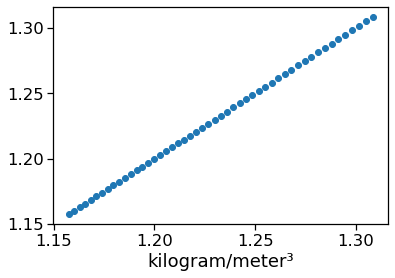

In [36]:
temps = np.linspace(-5,30)
rholist1 = []
rholist2 = []

for t in temps:
    rholist1.append(calculate_air_density(t, 1, 10))
    rholist2.append(density(1 * units.atm, t * units.degC, 10 * units('g/kg')))
    
fig, ax = plt.subplots()
ax.scatter(rholist2, rholist1)

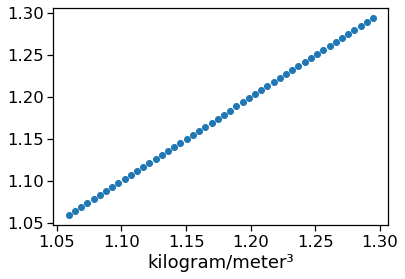

In [37]:
pressures = np.linspace(0.9,1.1)
rholist1 = []
rholist2 = []

for p in pressures:
    rholist1.append(calculate_air_density(25, p, 10))
    rholist2.append(density(p * units.atm, 25 * units.degC, 10 * units('g/kg')))
    
fig, ax = plt.subplots()
ax.scatter(rholist2, rholist1)

In [38]:
p = 1 * units.atm
T = 20 * units.degC
rh = 1.0
xH2O = mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')
density(p, T, xH2O * units('g/kg'))

1.2041180947480494 <Unit('kilogram / meter ** 3')>

In [39]:
p = 1000. * units.hPa
T = 28.1 * units.degC
rh = .65
mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')

15.764696916938787 <Unit('gram / kilogram')>

In [25]:
def kinematic_viscosity_air_checkunits(air_temperature, air_density):
    """
    Calculate the kinematic viscosity of air given the air temperature, pressure, and 100% relative humidity.

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        pressure (float): Pressure in atm.

    Returns:
        float: Kinematic viscosity of air in m^2/s.
    """
    # Convert air temperature to Kelvin
    T = air_temperature + 273.15
    
    rho_a = air_density

    # absolute viscosity of air (Sutherland's formula)
    mu_a = (1.458e-6 * T**1.5) / (T + 110.4) * units('kg/m/s') # units are kg/m/s
    
    # kinematic viscosity of air
    nu_a = mu_a / rho_a # units are m2/s
    
    return mu_a, nu_a

# Example usage:
air_temperature = 20  # degrees Celsius
pressure = 1          # atm

# Calculate kinematic viscosity of air
mu_a, nu_a = kinematic_viscosity_air_checkunits(20,1.22 * units('kg/m3'))
print("Kinematic viscosity of air:", nu_a)

Kinematic viscosity of air: 1.4863982640564129e-05 meter ** 2 / second


In [26]:
mu_a.units

<Unit('kilogram / meter / second')>

In [27]:
nu_a.units

<Unit('meter ** 2 / second')>

In [28]:
def kinematic_viscosity_air(air_temperature, air_density):
    """
    Calculate the kinematic viscosity of air given the air temperature, pressure, and 100% relative humidity.

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        pressure (float): Pressure in atm.

    Returns:
        float: Kinematic viscosity of air in m^2/s.
    """
    # Convert air temperature to Kelvin
    T = air_temperature + 273.15
    
    rho_a = air_density # units are kg/m3
    
    # absolute viscosity of air (Sutherland's formula)
    mu_a = (1.458e-6 * T**1.5) / (T + 110.4) # units are kg/m/s
    
    # kinematic viscosity of air
    nu_a = mu_a / rho_a # units are m2/s
    
    return mu_a, nu_a

# Example usage:
air_temperature = 20  # degrees Celsius
pressure = 1          # atm

# Calculate kinematic viscosity of air
mu_a, nu_a = kinematic_viscosity_air(20,1.22)
print("Kinematic viscosity of air:", nu_a)

Kinematic viscosity of air: 1.4863982640564129e-05


In [29]:
# check
from gasex.phys import kinematic_viscosity_air
kinematic_viscosity_air(20,1.22)

(1.8134058821488238e-05, 1.4863982640564129e-05)

In [30]:
def air_side_Schmidt_number_checkunits(air_temperature, air_density, gas=None, calculate=True):
    """
    Calculate the air-side Schmidt number for nitrous oxide (N2O).

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        sea_level_pressure (float): Sea level pressure in atm.
        rh (float): relative humidity (default: 1)
        gas: formula for gas (H2O, CO2, CH4, CO, SO2, O3, NH3, or N2O), formatted as a string, e.g. 'He'
        calculate: if True, calculate Schmidt number from diffusivity and kinematic viscosity of air;
                   if False, use default value from lookup table

    Returns:
        float: Air-side Schmidt number for nitrous oxide (N2O).
    """
    # Coefficients of diffusivity (cm2/s) of selected gases in air, Massman 1998
    diffusivities = {
        'H2O': 0.2178,
        'CO2': 0.1381,
        'CH4': 0.1952,
        'CO': 0.1807,
        'SO2': 0.1089,
        'O3': 0.1444,
        'NH3': 0.1978,
        'N2O': 0.1436,
    }
    
    # empirical values from de Richter et al., 2017
    schmidt_dict = {
        'H2O': 0.61,
        'CH4': 0.69,
        'N2O': 0.93,
    }

    # can calculate Schmidt number for gases that we have the diffusivities for
    if (gas in diffusivities.keys())&(calculate==True):
        # Convert air temperature to Kelvin
        T = air_temperature + 273.15
        # Constants for N2O
        molecular_diffusivity = diffusivities[gas]*1e-4 * units('m2/s')  # convert from cm^2/s to m2/s
        # Calculate air-side Schmidt number
        mu_a, nu_a = kinematic_viscosity_air_checkunits(air_temperature, air_density) # kg/m/s, m2/s
        ScA = nu_a / molecular_diffusivity # dimensionless
    # or look up an empirical value
    elif (gas in schmidt_dict.keys())&(calculate==False):
        ScA = schmidt_dict[gas] * units('dimensionless')
    # or just use default value of 0.9 for all other cases
    else:
        ScA = 0.9 * units('dimensionless')
    
    return ScA

# Example usage:
air_temperature = 20  # degrees Celsius
rhoa = 1.22 * units('kg/m3') # kg/m3
gas = "N2O"
ScA = air_side_Schmidt_number_checkunits(air_temperature, rhoa, gas=gas, calculate=True)
print(f"Air-side Schmidt number for {gas}: {ScA:.4}")

Air-side Schmidt number for N2O: 1.035 dimensionless


In [31]:
def air_side_Schmidt_number(air_temperature, air_density, gas=None, calculate=True):
    """
    Calculate the air-side Schmidt number for nitrous oxide (N2O).

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        sea_level_pressure (float): Sea level pressure in atm.
        rh (float): relative humidity (default: 1)
        gas: formula for gas (H2O, CO2, CH4, CO, SO2, O3, NH3, or N2O), formatted as a string, e.g. 'He'
        calculate: if True, calculate Schmidt number from diffusivity and kinematic viscosity of air;
                   if False, use default value from lookup table

    Returns:
        float: Air-side Schmidt number for nitrous oxide (N2O).
    """
    # Coefficients of diffusivity (cm2/s) of selected gases in air, 
    diffusivities = {
        'H2O': 0.2178, # Massman 1998
        'CO2': 0.1381, # Massman 1998
        'CH4': 0.1952, # Massman 1998
        'CO': 0.1807, # Massman 1998
        'SO2': 0.1089, # Massman 1998
        'O3': 0.1444, # Massman 1998
        'NH3': 0.1978, # Massman 1998
        'N2O': 0.1436, # Massman 1998
    }
    
    # empirical values from de Richter et al., 2017
    schmidt_dict = {
        'H2O': 0.61,
        'CH4': 0.69,
        'N2O': 0.93,
    }

    # can calculate Schmidt number for gases that we have the diffusivities for
    if (gas in diffusivities.keys())&(calculate==True):
        # Convert air temperature to Kelvin
        T = air_temperature + 273.15
        # Constants for N2O
        molecular_diffusivity = diffusivities[gas]*1e-4  # convert from cm^2/s to m2/s
        # Calculate air-side Schmidt number
        mu_a, nu_a = kinematic_viscosity_air(air_temperature, air_density)  # kg/m/s, m2/s
        ScA = nu_a / molecular_diffusivity # dimensionless
    # or look up an empirical value
    elif (gas in schmidt_dict.keys())&(calculate==False):
        ScA = schmidt_dict[gas]
    # or just use default value of 0.9 for all other cases
    else:
        ScA = 0.9
    
    return ScA

# Example usage:
air_temperature = 20  # degrees Celsius
rhoa = 1.22  # kg/m3
gas = "CO2"
ScA = air_side_Schmidt_number(air_temperature, rhoa, gas=gas, calculate=True)
print(f"Air-side Schmidt number for {gas}: {ScA:.4}")

Air-side Schmidt number for CO2: 1.076


In [32]:
# check
from gasex.diff import air_side_Schmidt_number
# Example usage:
air_temperature = 20  # degrees Celsius
rhoa = 1.22  # kg/m3
gas = "CO2"
ScA = air_side_Schmidt_number(air_temperature, rhoa, gas=gas, calculate=True)
print(f"Air-side Schmidt number for {gas}: {ScA:.4}")

Air-side Schmidt number for CO2: 1.076


In [33]:
def xH2O_from_rh(SP,pt,slp=1.0,rh=1.0):
    
    # Calculate vapor pressure at moist interface
    ph2oveq = vpress_sw(SP,pt) # atm
    ph2ov = rh * ph2oveq # atm
    
    molwt_h2o = 18.01528 # g/mol
    molwt_air = 28.96 # g/mol
    
    # Calculate mixing ratio
    mixing_ratio = molwt_h2o / molwt_air * ph2ov / (slp - ph2ov) * 1000  # Convert to g/kg

    return mixing_ratio

print(xH2O_from_rh(33,0,slp=1.0,rh=1.0))

3.7085260553248776


In [34]:
from gasex.phys import xH2O_from_rh
xH2O_from_rh(33,0,slp=1.0,rh=1.0)

3.7085260553248776

In [35]:
# don't take salinity into account
xH2O_from_rh(0,0,slp=1.0,rh=1.0)

3.775252511271652

In [36]:
# metpy function
mixing_ratio_from_relative_humidity(1 * units.atm, 0 * units.degC, 1.0).to('g/kg')

3.774458549148858 <Unit('gram / kilogram')>

In [37]:
def rh_from_dewpoint_SP_pt(SP, pt, dewpoint):
    # Calculate vapor pressure at moist interface
    es = vpress_sw(SP,pt) # atm
    e = vpress_sw(SP,dewpoint) # atm
    
    rh = e/es
    
    return rh

print(rh_from_dewpoint_SP_pt(33,30,20))

0.5507977020398768


In [38]:
from gasex.phys import rh_from_dewpoint_SP_pt
rh_from_dewpoint_SP_pt(33,30,20)

0.5507977020398768

In [39]:
def rh_from_dewpoint_t2m(t2m, dewpoint):
    # Calculate vapor pressure at moist interface
    es = vpress_w(t2m) # atm
    e = vpress_w(dewpoint) # atm
    
    rh = e/es
    
    return rh

print(rh_from_dewpoint_t2m(30, 20))

0.5507977020398768


In [40]:
from gasex.phys import rh_from_dewpoint_t2m
rh_from_dewpoint_t2m(30, 20)

0.5507977020398768

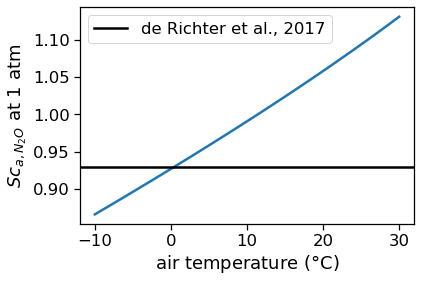

In [41]:
temps = np.linspace(-10,30)
schmidts = []
for t in temps:
    # calculate mixing ratio of water vapor in air
    xH2O = xH2O_from_rh(33,t,slp=1.0,rh=1.0)

    # Calculate density of air
    rhoa = density(1 * units.atm, t * units.degC, xH2O * units('g/kg')) # kg/m3
    
    # Calculate Schmidt number
    ScA = air_side_Schmidt_number_checkunits(t, rhoa, gas="N2O", calculate=True)
    schmidts.append(float(ScA))
    
fig, ax = plt.subplots()
ax.plot(temps, schmidts, label = None)
ax.set_xlabel("air temperature ($\degree$C)")
ax.set_ylabel("$Sc_{a,N_2O}$ at 1 atm")
ax.axhline(0.93, color='k', label = "de Richter et al., 2017")
ax.legend()

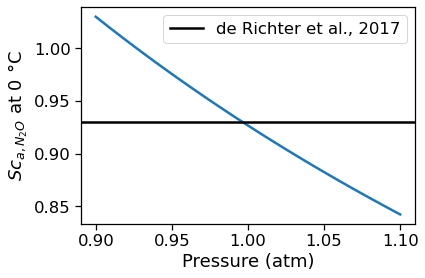

In [57]:
pressures = np.linspace(0.9,1.1)
schmidts = []
for p in pressures:
    # calculate mixing ratio of water vapor in air
    xH2O = xH2O_from_rh(33,0,slp=p,rh=1.0)

    # Calculate density of air
    rhoa = density(p * units.atm, 0 * units.degC, xH2O * units('g/kg')) # kg/m3
    
    # Calculate Schmidt number
    ScA = air_side_Schmidt_number_checkunits(0, rhoa, gas="N2O", calculate=True)
    schmidts.append(float(ScA))
    
fig, ax = plt.subplots()
ax.plot(pressures, schmidts)
ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("$Sc_{a,N_2O}$ at 0 $\degree$C")
ax.axhline(0.93, color='k', label = "de Richter et al., 2017")
ax.legend()

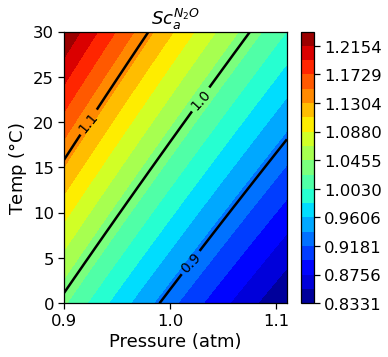

In [52]:
xmin = 0.9
xmax = 1.1
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        # calculate mixing ratio of water vapor in air
        xH2O = mixing_ratio_from_relative_humidity(x[j] * units.atm, y[k] * units.degC, 1.0).to('g/kg') # g/kg

        # Calculate density of air
        #rhoa = density(x[j] * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3
        rhoa = calculate_air_density(y[k], x[j], xH2O) * units('kg/m3')

        # Calculate Schmidt number
        ScA = air_side_Schmidt_number_checkunits(y[k], rhoa, gas="N2O", calculate=True)
        z[k,j] = float(ScA)
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{N_2O}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

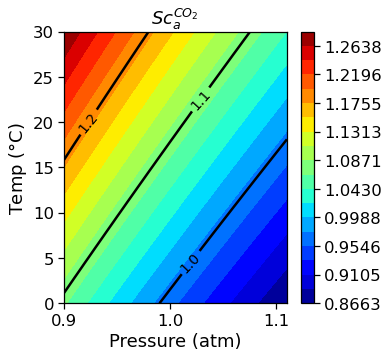

In [53]:
xmin = 0.9
xmax = 1.1
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        # calculate mixing ratio of water vapor in air
        xH2O = mixing_ratio_from_relative_humidity(x[j] * units.atm, y[k] * units.degC, 1.0).to('g/kg') # g/kg

        # Calculate density of air
        #rhoa = density(x[j] * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3
        rhoa = calculate_air_density(y[k], x[j], xH2O) * units('kg/m3')

        # Calculate Schmidt number
        ScA = air_side_Schmidt_number_checkunits(y[k], rhoa, gas="CO2", calculate=True)
        z[k,j] = float(ScA)
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{CO_2}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

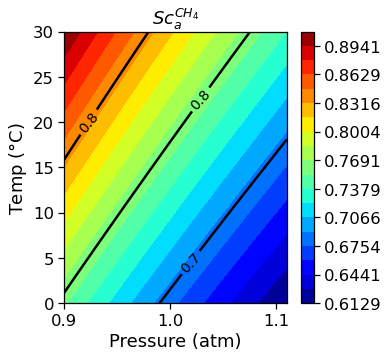

In [54]:
xmin = 0.9
xmax = 1.1
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        # calculate mixing ratio of water vapor in air
        xH2O = mixing_ratio_from_relative_humidity(x[j] * units.atm, y[k] * units.degC, 1.0).to('g/kg') # g/kg

        # Calculate density of air
        #rhoa = density(x[j] * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3
        rhoa = calculate_air_density(y[k], x[j], xH2O) * units('kg/m3')

        # Calculate Schmidt number
        ScA = air_side_Schmidt_number_checkunits(y[k], rhoa, gas="CH4", calculate=True)
        z[k,j] = float(ScA)
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{CH_4}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

In [42]:
@match_args_return
def schmidt_W92(pt,*,gas=None,sw=True):
    """Schmidt number @ 35 psu based on Wanninkhof 1992 Table A1

    Args:
        pt ([array like]): potential temperature  [degree C]
        gas ([string]): abbreviation for gas. Defaults to None.
        sw (bool, optional): if True, then calculates for SP = 35, of false, 
            calculates for fresh water. Defaults to True.

    Raises:
        ValueError: [description]

    Returns:
        [type]: Schmidt number [dimensionless]
    """
    W92_LIST = ('HE','NE','AR','O2','CH4','CO2','N2','KR','N2O','RN','SF6','CCL2','CCL3')
    g_up = gas.upper()
    if sw:
        A_dict = {
            'HE': (410.14, 20.503, 0.53175, 0.0060111),
            'NE': (855.1, 46.299, 1.254, 0.01449),
            'AR': (1909.1, 125.09, 3.9012, 0.048953),
            'O2': (1953.4, 128.00, 3.9918, 0.050091),
            'CH4': (2039.2, 120.31, 3.4209, 0.040437),
            'CO2': (2073.1, 125.62, 3.6276, 0.043219),
            'N2': (2206.1, 144.86, 4.5413, 0.056988),
            'KR': (2205.0, 135.71, 3.9549, 0.047339),
            'N2O': (2301.1, 151.1, 4.7364, 0.059431),
            'RN': (3412.8, 224.30, 6.7954, 0.08300),
            'SF6': (3531.6, 231.40, 7.2168, 0.090558),
            'CCL2': (3713.2, 243.30, 7.5879, 0.095215),
            'CCL3': (4039.8, 264.70, 8.2552, 0.10359)
        } if sw else {
            'HE': (377.09, 19.154, 0.50137, 0.005669),
            'NE': (764, 42.234, 1.1581, 0.013405),
            'AR': (1759.7, 117.37, 3.6959, 0.046527),
            'O2': (1800.6, 120.10, 3.7818, 0.047608),
            'CH4': (1897.8, 114.28, 3.2902, 0.039061),
            'CO2': (1911.1, 118.11, 3.4527, 0.041320),
            'N2': (1970.7, 131.45, 4.1390, 0.052106),
            'KR': (2032.7, 127.55, 3.7621, 0.045236),
            'N2O': (2055.6, 137.11, 4.3173, 0.054350),
            'RN': (3146.1, 210.48, 6.4486, 0.079135),
            'SF6': (3255.3, 217.13, 6.8370, 0.086070),
            'CCL2': (3422.7, 228.30, 7.1886, 0.090496),
            'CCL3': (3723.7, 248.37, 7.8208, 0.098455)
        }

    if g_up in A_dict.keys():
        A = A_dict[g_up]
    else:
        raise ValueError(f"gas {g_up} does not match one of {A_dict.keys()}")

    Sc = A[0] - A[1]*pt + A[2]*pt**2 - A[3]*pt**3
    return Sc

In [43]:
@match_args_return
def schmidt(SP,pt,*,gas=None, schmidt_parameterization=None):
    GAS_LIST = ('HE','NE','AR','KR','XE','N2','O2','CH4','N2','CO2')
    W14_LIST = ('CO2','N2O','CH4','RN','SF6','DMS','CFC12','CFC11','CH3BR','CCL4')
    W92_LIST = ('HE','NE','AR','O2','CH4','CO2','N2','KR','N2O','RN','SF6','CCL2','CCL3')
    
    g_up = gas.upper()
    
    if schmidt_parameterization is None:
        try:
            if g_up in GAS_LIST:
                return visc(SP, pt) / diff(SP, pt, gas=gas)
            elif g_up in W14_LIST:
                return schmidt_W14(pt, gas=gas, sw=True)
            elif g_up in W92_LIST:
                return schmidt_W92(pt, gas=gas, sw=True)
            else:
                raise ValueError(f"gas {g_up} does not match one of {set(GAS_LIST + W14_LIST + W92_LIST)}")
        except ValueError:
            raise ValueError(f"gas {g_up} does not match one of {set(GAS_LIST + W14_LIST + W92_LIST)}")
    
    if g_up:
        if g_up not in GAS_LIST and g_up not in W14_LIST and g_up not in W92_LIST:
            raise ValueError(f"gas {g_up} does not match one of {set(GAS_LIST + W14_LIST + W92_LIST)}")
        
        if g_up in GAS_LIST and schmidt_parameterization == "viscdiff":
            return visc(SP, pt) / diff(SP, pt, gas=gas)
        
        if g_up in W14_LIST and schmidt_parameterization == "W14":
            return schmidt_W14(pt, gas=gas, sw=True)
        
        if g_up in W92_LIST and schmidt_parameterization == "W92":
            return schmidt_W92(pt, gas=gas, sw=True)
        
        if schmidt_parameterization == "viscdiff":
            return visc(SP, pt) / diff(SP, pt, gas=gas)
        
        if schmidt_parameterization == "W14":
            return schmidt_W14(pt, gas=gas, sw=True)
        
        if schmidt_parameterization == "W92":
            return schmidt_W92(pt, gas=gas, sw=True)
    
    raise ValueError(f"Invalid combination of gas {g_up} and schmidt_parameterization {schmidt_parameterization}")

In [44]:
from gasex.diff import schmidt, schmidt_W14, schmidt_W92
print(schmidt(33,20, gas="CO2"))
print(schmidt_W14(20,gas="CO2",sw=True))
print(schmidt_W92(20,gas="CO2",sw=True))

652.7016299275649
668.344
665.9879999999998


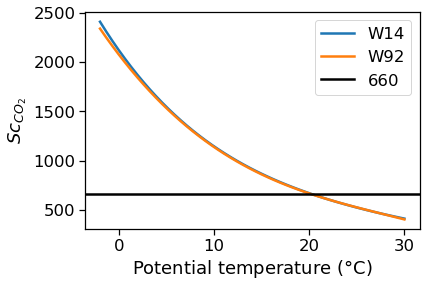

In [45]:
temps = np.linspace(-2,30)
schmidt14 = []
schmidt92 = []
for t in temps:
    schmidt14.append(schmidt_W14(t,gas='CO2',sw=True))
    schmidt92.append(schmidt_W92(t,gas='CO2',sw=True))
    
fig, ax = plt.subplots()
ax.plot(temps, schmidt14, label = "W14")
ax.plot(temps, schmidt92, label = "W92")
ax.set_xlabel("Potential temperature ($\degree$C)")
ax.set_ylabel("$Sc_{CO_2}$")
ax.axhline(660, label = "660", color = "k")
ax.legend()

## wind-dependent terms
The wind speed-dependent terms are $k_s$, $k_c$, $k_p$, and $\Delta P$.

### flux equations
L13 equation 3:
$$F_d = K_s G_{eq} (slp_{corr} - G_{sat}) $$
and
$$F_p = K_b G_{eq} ((1+\Delta P) slp_{corr} - G_{sat})$$
L13 eqn. 15:
$$F_c = x_G5.56 (u^*_w)^{3.86}$$
where
$$\Delta P = 152.44 u*^{1.06} \% $$

### piston velocity equations
L13 eqn. 9/Fairall eqn. 11:
$$k_s = \frac{u*}{r_{wt}+\alpha r_a}\ m/s$$
L13 eqn. 14:
$$k_b = 1.98x10^6 u*^{2.76}(\frac{Sc^{gas}}{660})^{-2/3}\ cm/hr$$
L13 eqn. 15/Emerson and Bushinsky eqn. A20:
$$k_c = 5.56(u*)^{3.86}\ mol/m^2/s$$

In [72]:
# Keyword argument "return_vars" makes L13 function flexible,
# allowing it to return more variables without breaking the existing code
@match_args_return
def L13unitcheck(C,u10,SP,pt,*,slp=1.0,gas=None,rh=1.0,chi_atm=None,
                 air_temperature=None, calculate_schmidtair=True, schmidt_parameterization=None,
                return_vars=None, Ks = None, Kb=None, Kc=None, dP=None, beta=1.0, pressure_mode=False):
    # -------------------------------------------------------------------------
    # Convert inputs to arrays to be able to use metpy.units
    # -------------------------------------------------------------------------
    C = np.array(C)
    u10 = np.array(u10)
    SP = np.array(SP)
    pt = np.array(pt)
    slp = np.array(slp)
    rh = np.array(rh)
    if chi_atm is not None:
        chi_atm = np.array(chi_atm)
    if air_temperature is not None:
        air_temperature = np.array(air_temperature)
    # -------------------------------------------------------------------------
    # Conversion factors & assign units
    # -------------------------------------------------------------------------
    m2cm = 100 * units('cm/m') # cm in a meter
    h2s = 3600 * units('s/hr') # sec in hour
    atm2pa = 101325.0 * units('kg/(m s2 atm)') # express in terms of SI base units: 1 Pa = kg/m/s2
    R = 8.3144598 * units('kg*m2/(s2 mol K)') # express in terms of SI base units: 1 J = kg*m2/s2
    # -------------------------------------------------------------------------
    # Calculate water vapor pressure and adjust sea level pressure
    # -------------------------------------------------------------------------

    # if humidity is not provided, set to 1 for all values
    ph2oveq = vpress_sw(SP,pt) * units('atm')
    ph2ov = rh * ph2oveq

    # slpc = (observed dry air pressure)/(reference dry air pressure)
    slp_corr = (slp*units.atm - ph2ov) /(1*units.atm - ph2oveq)
    
    # -------------------------------------------------------------------------
    # Calculate air density and Schmidt number if air temperature is not None
    # -------------------------------------------------------------------------
    if air_temperature is not None:
        # Convert air temperature to Kelvin
        T = (air_temperature + 273.15)

        # calculate mixing ratio of water vapor in air
        #xH2O = mixing_ratio_from_relative_humidity(slp * units.atm, air_temperature * units.degC, rh).to('g/kg')
        xH2O = xH2O_from_rh(SP,pt,slp=slp,rh=rh)

        # Calculate density of air
        #rhoa = density(slp * units.atm, air_temperature * units.degC, xH2O * units('g/kg'))
        rhoa = calculate_air_density(air_temperature, slp, xH2O)*units('kg/m3')

        # air-side schmidt number
        ScA = air_side_Schmidt_number_checkunits(air_temperature, rhoa, gas=gas, calculate=calculate_schmidtair)

    else:
        rhoa = 1.225 * units('kg/m3') # density of air
        ScA = 0.9 * units('dimensionless')
    # -------------------------------------------------------------------------
    # Parameters for COARE 3.0 calculation - diffusive gas exchange
    # -------------------------------------------------------------------------

    # Calculate potential density at surface
    SA = SP * 35.16504 / 35
    CT = CT_from_pt(SA,pt)
    rhow = rho(SA,CT,0*CT)*units('kg/m3') # density of water

    lam = 13.3 # numerator in Fairall et al., 2011 eqn. (14). Not sure about units but Lam/A/phi is dimensionless
    A = 1.3 # constant, determined empirically by Fairall et al. (2011)
    phi = 1 # buoyancy term. Except for light wind cases, phi=1 (Fairall et al., 2011)
    tkt = 0.01 * units('m') # molecular sublayer thickness, ~1 mm (Fairall et al., 2011)
    hw = lam /A / phi # eqn. 14 of Fairall et al., 2011
    ha = lam # defined as 13.3 in Fairall et al., 2011
    zw = 0.5 * units('m')
    za = 1.0 # atmospheric measurement height - should this be 2 if the air temp. and dewpoint are from 2m?
    kappa = 0.4 # defined as 0.4 in Fairall et al., 2011

    # -------------------------------------------------------------------------
    # Calculate gas physical properties
    # -------------------------------------------------------------------------
    if chi_atm is None:
        xG = air_mol_fract(gas=gas)
        s = sol_SP_pt(SP,pt,chi_atm=xG, gas=gas,units="mM")*units('mol/m3/atm')
        Geq = eq_SP_pt(SP,pt,gas=gas,slp=slp,units="mM")*units('mol/m3')
        print(Geq)
        Patm = Geq / s
    else:
        xG = chi_atm
        f  = fugacity_factor(pt,gas=gas,slp=slp)
        s = sol_SP_pt(SP,pt,chi_atm=xG, gas=gas,units="mM")*units('mol/m3/atm')
        Patm = xG * f * (slp * units('atm') - ph2ov)
        Geq = Patm * s

    T = pt * units.degC
    T = T.to('K')
    alc0 = (Geq / (1 * units('atm') * atm2pa)) * R * T # original: I think this assumes the barometric pressure is 1 atm?
    alc = (Geq / (slp * units('atm') * atm2pa)) * R * T # dividing by slp makes alc dimensionless

    if pressure_mode is True:
        # if pressure_mode is True "C" is Psw - Patm
        Psw = C * units('atm')# + Patm
        Gsat = Psw / Patm
        #print("Gsat: :", Gsat)
    else:
        Gsat = C * units('mol/m3') / Geq
        # check to make sure Gsat is the same as Psw/Patm
        Psw = C * units('mol/m3') / s
        supersat = Psw / Patm
        #print("Gsat: :", Gsat)
        #print("supersat: ", supersat)
        #print("DP = ", Psw - Patm)

    #print("Psw: ", Psw)
    #print("Patm: ", Patm)

    ScW = schmidt(SP,pt,gas=gas, schmidt_parameterization=schmidt_parameterization)

    # -------------------------------------------------------------------------
    # Calculate COARE 3.0 and gas transfer velocities
    # -------------------------------------------------------------------------
    # ustar
    cd10 = cdlp81(u10) # L13 eqn. 13
    ustar = u10 * np.sqrt(cd10)
    
    # water-side ustar - L13 eqn. 12
    ustarw = ustar / np.sqrt(rhow / rhoa)

    # water-side resistance to transfer
    # eqn. 13 of Fairall et al., 2011
    rwt = np.sqrt(rhow / rhoa) * (hw * np.sqrt(ScW)+(np.log(zw / tkt) / kappa)) # Fairall et al. 2011 define k as 0.4

    # air-side resistance to transfer
    # eqn. 15 of Fairall et al., 2011
    rat = ha * np.sqrt(ScA) + za / np.sqrt(cd10) - 5 + 0.5 * np.log(ScA) / kappa

    # diffusive gas transfer coefficient (L13 eqn 9/Fairall 2011 eqn. 11)
    if Ks is None:
        Ks = ustar / (rwt + rat * alc) * units('m/s')
    else: Ks = Ks * units('meter / second')

    # large bubble transfer velocity (L13 eqn 14)
    if Kb is None:
        Kb = 1.98e6 * ustarw**2.76 * (ScW / 660)**(-2/3) * units('cm/hr') / (m2cm * h2s)
    else: Kb = Kb * units('meter / second')
    
    # small bubble transfer coefficient (L13 eqn 15)
    if Kc is None:
        Kc = 5.56 * ustarw ** 3.86 * units('mol/(m2 s)') # L13 eqn 15
    else: Kc = Kc*units('mole / meter ** 2 / second')

    # overpressure dependence on windspeed (L13 eqn 16)
    if dP is None:
        dP = 1.5244 * ustarw**1.06 * units('dimensionless') # equivalent to 152.44ustarw**1.06 %
    else: dP = dP * units('dimensionless')

    # -------------------------------------------------------------------------
    # Calculate air-sea fluxes
    # -------------------------------------------------------------------------

    Fd = Ks * Geq * (slp_corr - Gsat) # Fs in L13 eqn 3
    Fp = beta * Kb * Geq * ((1+dP) * slp_corr - Gsat) # Fp in L13 eqn 3, modified by Emerson et al. 2019   
    Fc = beta * xG * Kc # Fc in L13 eqn 3, modified by Emerson et al. 2019 

    # -------------------------------------------------------------------------
    # Calculate steady-state supersaturation
    # -------------------------------------------------------------------------
    # L13 eqn 5
    Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr)
    
    # -------------------------------------------------------------------------
    # define which variables get returned
    # -------------------------------------------------------------------------
    if return_vars is None:
        return_vars = ['Fd', 'Fc', 'Fp', 'Deq', 'Ks']
    elif isinstance(return_vars, tuple):
        return_vars = [elem for elem in return_vars]
    elif isinstance(return_vars, str):
        return_vars = [return_vars]
    
    # Dictionary of all variables
    all_vars = {
        'Fd': Fd,
        'Fc': Fc,
        'Fp': Fp,
        'Deq': Deq,
        'Ks': Ks,
        'Kb': Kb,
        'Kc': Kc,
        'dP': dP,
        'ScW': ScW,
        'Geq': Geq,
        'ustarw': ustarw,
        'rwt': rwt,
        'rat': rat
    }

    # Return only the requested variables
    return tuple(all_vars[var] for var in return_vars)

In [47]:
L13unitcheck(18e-6,20,33,0,gas='N2O',chi_atm=338e-9,
             air_temperature=30, calculate_schmidtair=True,
             rh = 1.0,schmidt_parameterization="W92",
            return_vars = ['Ks', 'Kb', 'Kc', 'dP'],
            #Ks = 5, Kb = 0.0001, Fc=2e-12
            )

(5.7029581918601975e-05 <Unit('meter / second')>,
 0.00013063954031218992 <Unit('meter / second')>,
 6.074093375670624e-06 <Unit('mole / meter ** 2 / second')>,
 0.03515421919620151 <Unit('dimensionless')>)

In [48]:
L13unitcheck(3.5889386868956154e-08,20,33,0,gas='N2O',chi_atm=338e-9,
             air_temperature=30, calculate_schmidtair=True,
             rh = 1.0,schmidt_parameterization="W92",
            return_vars = ['Ks', 'Kb', 'Kc', 'dP'],
            Ks = 5, Kb = 0.0001, Kc=6e-06, dP=0.035,
             pressure_mode=True)

(5.0 <Unit('meter / second')>,
 0.0001 <Unit('meter / second')>,
 6e-06 <Unit('mole / meter ** 2 / second')>,
 0.035 <Unit('dimensionless')>)

In [49]:
L13unitcheck(10e-6,20,33,0,gas='N2O',chi_atm=338e-9,
             air_temperature=30, calculate_schmidtair=True,
             rh = 1.0,schmidt_parameterization="W92",
             Ks = 5, Kb = 0.0001,
            return_vars = ['Fd', 'Fc', 'Fp', 'Deq', 'Ks', 'Kc', 'ScW', 'Geq', 'Kb', 'ustarw'])

(3.1276809199987016e-05 <Unit('mole / meter ** 2 / second')>,
 2.053043560976671e-12 <Unit('mole / meter ** 2 / second')>,
 6.826806393234243e-10 <Unit('mole / meter ** 2 / second')>,
 7.283297110336214e-07 <Unit('dimensionless')>,
 5.0 <Unit('meter / second')>,
 6.074093375670624e-06 <Unit('mole / meter ** 2 / second')>,
 2301.1,
 1.6255361839997404e-05 <Unit('mole / meter ** 3')>,
 0.0001 <Unit('meter / second')>,
 0.02854603342915845 <Unit('dimensionless')>)

In [74]:
280*1e-3

0.28

In [77]:
(Fd, Fc, Fp) = L13unitcheck(370*1e-3,20,31,-0.5,gas='O2',
                           return_vars = ["Fd", "Fc", "Fp"])
print((Fd + Fc + Fp)*1e6)

0.37275911654560756 mole / meter ** 3
[4.382764202792116] mole / meter ** 2 / second


In [67]:
L13unitcheck(1e-3,20,33,0,gas='Ar', beta=0.37)

(1.2843445496759864e-06 <Unit('mole / meter ** 2 / second')>,
 array([2.32320685e-08]) <Unit('mole / meter ** 2 / second')>,
 1.3065540151374996e-06 <Unit('mole / meter ** 2 / second')>,
 array([0.0309237]) <Unit('dimensionless')>,
 7.671653763795444e-05 <Unit('meter / second')>)

In [68]:
@match_args_return
def L13(C,u10,SP,pt,*,slp=1.0,gas=None,rh=1.0,chi_atm=None, air_temperature=None,
        calculate_schmidtair=True, schmidt_parameterization=None, return_vars=None,
       Ks = None, Kb=None, Kc=None, dP=None, beta=1.0, pressure_mode=False):
    # -------------------------------------------------------------------------
    # Conversion factors & assign units
    # -------------------------------------------------------------------------
    m2cm = 100 # cm in a meter, cm/m
    h2s = 3600# sec in hour, s/hr
    atm2pa = 101325.0 # Pa per atm, Pa/atm, 1 Pa = kg/m/s2
    R = 8.3144598 # ideal gas constant, J/(mol K), 1 J = kg*m2/s2
    # -------------------------------------------------------------------------
    # Calculate water vapor pressure and adjust sea level pressure
    # -------------------------------------------------------------------------

    # if humidity is not provided, set to 1 for all values
    ph2oveq = vpress_sw(SP,pt) # atm
    ph2ov = rh * ph2oveq # atm

    # slpc = (observed dry air pressure)/(reference dry air pressure)
    slp_corr = (slp - ph2ov) /(1 - ph2oveq) # dimensionless
    
    # -------------------------------------------------------------------------
    # Calculate air density and Schmidt number if air temperature is not None
    # -------------------------------------------------------------------------
    if air_temperature is not None:
        # Convert air temperature to Kelvin
        T = (air_temperature + 273.15) # K

        # calculate mixing ratio of water vapor in air
        #xH2O = mixing_ratio_from_relative_humidity(slp * units.atm, air_temperature * units.degC, rh).to('g/kg') # g/kg
        xH2O = xH2O_from_rh(SP,pt,slp=slp,rh=rh)

        # Calculate density of air
        #rhoa = density(np.array(slp) * units.atm, np.array(air_temperature) * units.degC, np.array(xH2O) * units('g/kg')) # kg/m3
        # drop metpy units for computational efficiency
        #rhoa = rhoa.magnitude
        rhoa = calculate_air_density(air_temperature, slp, xH2O)

        # air-side schmidt number, dimensionless
        ScA = air_side_Schmidt_number(air_temperature, rhoa, gas=gas, calculate=calculate_schmidtair)

    else:
        rhoa = 1.225 # default density of air, kg/m3
        ScA = 0.9 # default air Schmidt number, dimensionless
    # -------------------------------------------------------------------------
    # Parameters for COARE 3.0 calculation - diffusive gas exchange
    # -------------------------------------------------------------------------

    # Calculate potential density at surface
    SA = SP * 35.16504 / 35 # absolute salinity, psu
    CT = CT_from_pt(SA,pt) # conservative temperature, degrees C
    rhow = rho(SA,CT,0*CT) # density of water, kg/m3

    # Constants for COARE 3.0 calculation
    lam, A, phi, tkt, hw, ha, zw, za, kappa = 13.3, 1.3, 1, 0.01, 13.3/1.3, 13.3, 0.5, 1.0, 0.4

    # -------------------------------------------------------------------------
    # Calculate gas physical properties
    # -------------------------------------------------------------------------
    if chi_atm is None:
        xG = air_mol_fract(gas=gas)
        s = sol_SP_pt(SP,pt,chi_atm=xG, gas=gas,units="mM")
        Geq = eq_SP_pt(SP,pt,gas=gas,slp=slp,units="mM")
        Patm = Geq / s
    else:
        xG = chi_atm
        f  = fugacity_factor(pt,gas=gas,slp=slp)
        s = sol_SP_pt(SP,pt,chi_atm=xG, gas=gas,units="mM")
        Patm = xG * f * (slp - ph2ov)
        Geq = Patm * s

    T = pt + 273.15 # K
    alc0 = (Geq / atm2pa) * R * (pt+K0) # original: I think this assumes the barometric pressure is 1 atm?
    alc = (Geq / (slp * atm2pa)) * R * T # dividing by slp makes alc dimensionless
    
    if pressure_mode is True:
        # if pressure_mode is True C is Psw - Patm
        Psw = C
        Gsat = Psw / Patm
    else:
        Gsat = C / Geq # dimensionless

    ScW = schmidt(SP,pt,gas=gas,schmidt_parameterization=schmidt_parameterization) # dimensionless

    # -------------------------------------------------------------------------
    # Calculate COARE 3.0 and gas transfer velocities
    # -------------------------------------------------------------------------
    # ustar
    # eqns. 12 and 13 of Liang et al., 2013
    cd10 = cdlp81test(u10) # dimensionless?
    ustar = u10 * np.sqrt(cd10) # m/s. using u10*np.sqrt(rhoa*cd10/rhow) (L13 equation 12) throws everything off
    
    # water-side ustar
    ustarw = ustar / np.sqrt(rhow / rhoa) # m/s

    # water-side resistance to transfer, dimensionless
    # eqn. 13 of Fairall et al., 2011
    rwt = np.sqrt(rhow / rhoa) * (hw * np.sqrt(ScW)+(np.log(zw / tkt) / kappa)) # Fairall et al. 2011 define k as 0.4

    # air-side resistance to transfer, dimensionless
    # eqn. 15 of Fairall et al., 2011
    rat = ha * np.sqrt(ScA) + za / np.sqrt(cd10) - 5 + 0.5 * np.log(ScA) / kappa

    # diffusive gas transfer coefficient (L13 eqn 9/Fairall 2011 eqn. 11)
    if Ks is None:
        Ks = ustar / (rwt + rat * alc) # m/s
    # bubble transfer velocity (L13 eqn 14)
    if Kb is None:
        Kb = 1.98e6 * ustarw**2.76 * (ScW / 660)**(-2/3) / (m2cm * h2s) # m/s
    # small bubble transfer coefficient (L13 eqn 15)
    if Kc is None:
        Kc = 5.56 * ustarw**3.86 # mol/m2/s
    # overpressure dependence on windspeed (L13 eqn 16)
    if dP is None:
        dP = 1.5244 * ustarw**1.06 # %

    # -------------------------------------------------------------------------
    # Calculate air-sea fluxes
    # -------------------------------------------------------------------------

    Fd = Ks * Geq * (slp_corr - Gsat) # Fs in L13 eqn 3, units are mol/m2/s
    Fp = beta * Kb * Geq * ((1+dP) * slp_corr - Gsat) # Fp in L13 eqn 3, units are mol/m2/s
    Fc = beta * xG * Kc # L13 eqn 15, units are mol/m2/s

    # -------------------------------------------------------------------------
    # Calculate steady-state supersaturation
    # -------------------------------------------------------------------------
    # L13 eqn 5
    # Deq = supersaturation at which the total gas flux between ocean and atmosphere = 0
    # bubble-mediated flux into the ocean is balanced by diffusive flux out of the ocean
    Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage

    # -------------------------------------------------------------------------
    # define which variables get returned
    # -------------------------------------------------------------------------
    # Return requested variables
    if return_vars is None:
        return_vars = ['Fd', 'Fc', 'Fp', 'Deq', 'Ks']
    
    if isinstance(return_vars, str):
        return_vars = [return_vars]
    
    # Dictionary of all variables
    all_vars = {
        'Fd': Fd,
        'Fc': Fc,
        'Fp': Fp,
        'Deq': Deq,
        'Ks': Ks,
        'Kb': Kb,
        'Kc': Kc,
        'dP': dP,
        'ScW': ScW,
        'Geq': Geq,
        'ustarw': ustarw,
        'rwt': rwt,
        'rat': rat
    }

    # Return only the requested variables
    return tuple(all_vars[var] for var in return_vars)

In [69]:
def cdlp81test( u10):
    # Calculates drag coefficient from u10, wind speed at 10 m height

    cd = 4.9e-4 + 6.5e-5 * u10
    if (isinstance(cd,float)):
        cd = np.asarray(cd)
    cd = np.where(u10 <= 11, 0.0012, cd)
    cd = np.where(u10 >= 20, 0.0018, cd)
    return cd

#cdlp81test(n2ods.windspeed_m_s)

In [70]:
from gasex.airsea import kgas
def fsa(C,u10,SP,T,*,slp=1.0,gas=None,param="W14",rh=1,chi_atm=None):
    """
    DESCRIPTION
    -------------
    Diffusive gas flux across the air-sea interface in mol m-2 s-1

    F = k (C - Ceq_slp)

    INPUTS:
    ----------
    C         Surface dissolved gas concentration       [mol m-3 == mmol L-1]
    u10       10-m wind speed                           [m s-1]
    SP        Practical Salinity                         --
    T         Surface water temperature                 [deg C ]
    slp       Sea-level pressure                        [atm]
    gas       abbr. for gas of interest
    param     abbr. for the air-sea parameterization
    rh        fractional relative humidity (1 = 100)

    OUTPUT:
    ----------
    air sea gas flux (positive out of ocean) in mol m-2 s-1

    AUTHOR: David Nicholson
    """
    slp_corr = (slp - vpress_sw(SP,T)) / (1 - vpress_sw(SP,T))
    # equilibrium conc. [mol L-1 == mmol m-3]
    C_eq = eq_SP_pt(SP,T,gas=gas,slp=slp,chi_atm=chi_atm)
    Sc = schmidt(SP,T,gas=gas)
    # piston velocity [m s-1]
    k = kgas(u10,Sc,param=param)
    Fd = k * (C - C_eq) #* slp_corr) don't need slp_corr because it's now built into eq_SP_pt function
    return Fd

In [71]:
def fsa_pC(pC_w,pC_a,u10,SP,T,*,gas=None,param="W14",chi_atm=None):
    """
    DESCRIPTION
    -------------
    Diffusive gas flux across the air-sea interface in mol m-2 s-1

    INPUTS:
    ----------
    pC_w      dissolved partial pressure (or fugacity)  [uatm]
    pC_a      air-side partial pressure (or fugacity)   [uatm]
    u10       10-m wind speed                           [m s-1]
    SP        Practical Salinity                         --
    T         Surface water temperature                 [deg C ]
    slp       Sea-level pressure                        [atm]
    gas       abbr. for gas of interest
    param     abbr. for the air-sea parameterization

    OUTPUT:
    ----------
    air sea gas flux (positive out of ocean) in mmol m-2 s-1

    AUTHOR: David Nicholson
    """

    # K0 in mmol L-1 atm-1 == mol m-3 atm-1
    s = sol_SP_pt(SP,T,chi_atm=xG, gas=gas,units="mM")
    Sc = schmidt(SP,T,gas=gas)
    # piston velocity m s-1
    k = kgas(u10,Sc,param=param)
    # m s-1 * mol m-3 atm -1 * atm == mol m-2 s-1
    Fd = k * s * (pC_w - pC_a) / 1e6
    return Fd

In [72]:
# test conditions
pt = 0
SP = 33
u10 = 20
slp = 0.9
xG = 338e-9
gas = "N2O"
rh = 1.0
pN2O = 200e-9

ph2oveq = vpress_sw(SP,pt) # atm
ph2ov = rh * ph2oveq # atm
f  = fugacity_factor(pt,gas=gas,slp=slp)
s = sol_SP_pt(SP,pt,chi_atm=xG, gas=gas,units="mM")
pN2Oatm = xG * f * (slp - ph2ov)
Geq = pN2Oatm * s
C = pN2O * s

In [73]:
from gasex.sol import sol_SP_pt,eq_SP_pt, air_mol_fract
eq_SP_pt(SP,pt,gas=gas,slp=slp,chi_atm=xG)

1.4629240102106469e-05

In [74]:
F = fsa(C,u10,SP,pt,slp=slp,gas='N2O',param="W14",rh=rh,
        chi_atm=xG)
-F*86400*1e6

62.57790165027015

In [75]:
pC_w = pN2O*1e6 # need to convert to uatm
pC_a = pN2Oatm*1e6

F = fsa_pC(pC_w,pC_a,u10,SP,pt,gas='N2O',param="W14",chi_atm=xG)
-F*86400*1e6

62.577901650270185

In [76]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(C,u10,SP,pt,slp=slp,gas='N2O',rh=rh,chi_atm=xG,
                                 air_temperature=pt, calculate_schmidtair=True,
                                 return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"],
                                 pressure_mode=False)
F = (Fd+Fc+Fp)*86400*1e6
F

60.116443992821836

In [77]:
Fd,Fc,Fp,Deq,dP,Ks,Kt,ScW,Geq = L13(pN2O,u10,SP,pt,slp=slp,gas='N2O',rh=rh,chi_atm=xG,
                                 air_temperature=pt, calculate_schmidtair=True,
                                 return_vars = ["Fd","Fc","Fp","Deq","dP","Ks","Kc","ScW","Geq"],
                                 pressure_mode=True)
F = (Fd+Fc+Fp)*86400*1e6
F

60.116443992821864

In [78]:
C = pN2O * s
C

9.72230685563306e-06

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_64819/1720585489.py:132: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


At SP = 33, pt = 15 deg C, pN2Osw = 332.0 natm, and SLP = 1 atm, W14 is net out but L13 is net in.


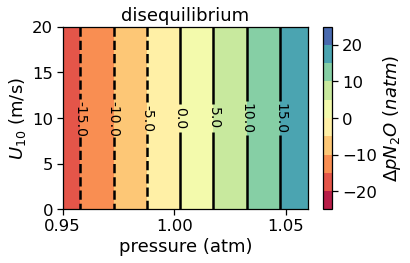

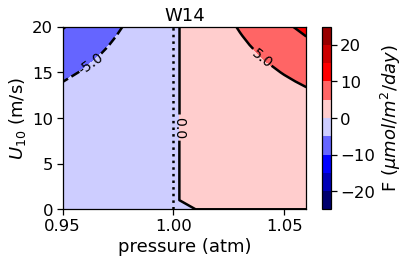

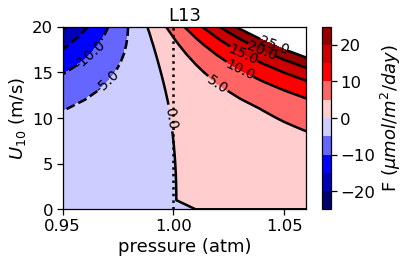

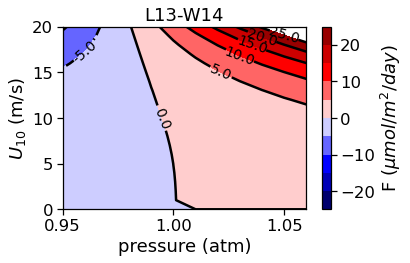

In [79]:
# test conditions
pt = 15
SP = 33
u10 = 20
xG = 338e-9
gas = "N2O"
rh = 1.0
pN2O = 332e-9
Dcmap = "Spectral"
Fcmap = "seismic"

# calculations that don't depend on SLP or wind speed
pC_w = pN2O*1e6 # need to convert to uatm
ph2oveq = vpress_sw(SP,pt) # atm
ph2ov = rh * ph2oveq # atm
s = sol_SP_pt(SP,pt,chi_atm=xG, gas=gas,units="mM")

# x is atmospheric pressure
xmin = 0.95
xmax = 1.05
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

# y is wind speed
ymin = 0
ymax = 20
dy = 1
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

DpN2Oarray = np.zeros((Ny, Nx))
FW14array = np.zeros((Ny, Nx))
FL13array = np.zeros((Ny, Nx))
Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
dParray = np.zeros((Ny, Nx))
Deqarray = np.zeros((Ny, Nx))
pressuretermarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        # calculate pressure-dependent params to feed into fsa_pC
        f  = fugacity_factor(pt,gas=gas,slp=x[j])
        pN2Oatm = xG * f * (x[j] - ph2ov)
        pC_a = pN2Oatm*1e6
        
        DpN2Oarray[k,j] = (pN2Oatm - pN2O)*1e9

        FW14 = fsa_pC(pC_w,pC_a,y[k],SP,pt,gas='N2O',param="W14",chi_atm=xG)
        FW14 = -FW14*86400*1e6 # convert from mol/m2/s to umol/m2/day
        
        FW14array[k,j] = FW14
        
        Fd,Fc,Fp,Deq,dP,Ks,Kt,ScW,Geq = L13(pN2O,y[k],SP,pt,slp=x[j],gas='N2O',rh=rh,chi_atm=xG,
                                 air_temperature=pt, calculate_schmidtair=True,
                                 return_vars = ["Fd","Fc","Fp","Deq","dP","Ks","Kc","ScW","Geq"],
                                 pressure_mode=True)
        
        FL13 = (Fd + Fc + Fp)*86400*1e6
        FL13array[k,j] = FL13
        Fdarray[k,j] = Fd*86400*1e6
        Fcarray[k,j] = Fc*86400*1e6
        Fparray[k,j] = Fp*86400*1e6
        dParray[k,j] = dP
        Deqarray[k,j] = Deq
        
        slp_corr = (x[j] - ph2ov) /(1 - ph2oveq) # dimensionless
        Gsat = pN2O / pN2Oatm
        pressureterm = ((1+dP)*slp_corr - Gsat)
        pressuretermarray[k,j] = pressureterm

fig, ax = plt.subplots()
z = DpN2Oarray
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Dcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')

ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title("disequilibrium")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"$\Delta pN_2O\ (natm)$")
plt.tight_layout()
plt.savefig('figures/DpN2Ocontours.pdf')

fig, ax = plt.subplots()
z = FW14array
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.axvline(1, color = "k", linestyle = ":")
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"W14")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"F $(\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/W14contours.pdf')

fig, ax = plt.subplots()
z = FL13array
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.axvline(1, color = "k", linestyle = ":")
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"L13")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"F $(\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/L13contours.pdf')

fig, ax = plt.subplots()
z = FL13array - FW14array
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')

ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"L13-W14")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"F $(\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/L13-W14contours.pdf')

print(f"At SP = {SP}, pt = {pt} deg C, pN2Osw = {pN2O*1e9} natm, and SLP = 1 atm, W14 is net out but L13 is net in.")

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_64819/1720585489.py:132: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


At SP = 33, pt = 0 deg C, pN2Osw = 337.0 natm, and SLP = 1 atm, W14 is net out but L13 is net in.


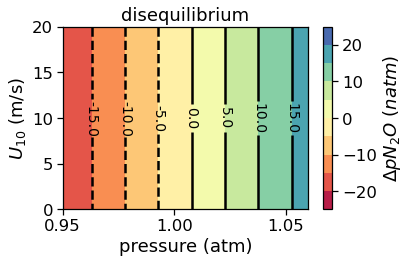

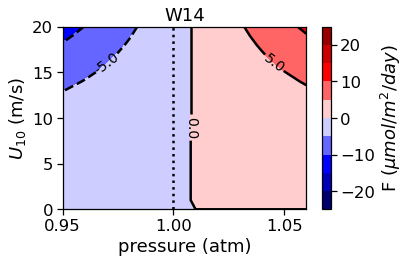

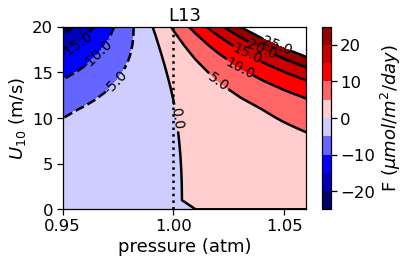

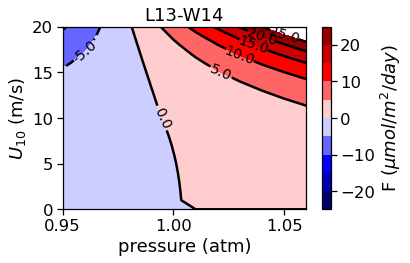

In [80]:
# test conditions
pt = 0
SP = 33
u10 = 20
xG = 338e-9
gas = "N2O"
rh = 1.0
pN2O = 337e-9
Dcmap = "Spectral"
Fcmap = "seismic"

# calculations that don't depend on SLP or wind speed
pC_w = pN2O*1e6 # need to convert to uatm
ph2oveq = vpress_sw(SP,pt) # atm
ph2ov = rh * ph2oveq # atm
s = sol_SP_pt(SP,pt,chi_atm=xG, gas=gas,units="mM")

# x is atmospheric pressure
xmin = 0.95
xmax = 1.05
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

# y is wind speed
ymin = 0
ymax = 20
dy = 1
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

DpN2Oarray = np.zeros((Ny, Nx))
FW14array = np.zeros((Ny, Nx))
FL13array = np.zeros((Ny, Nx))
Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
dParray = np.zeros((Ny, Nx))
Deqarray = np.zeros((Ny, Nx))
pressuretermarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        # calculate pressure-dependent params to feed into fsa_pC
        f  = fugacity_factor(pt,gas=gas,slp=x[j])
        pN2Oatm = xG * f * (x[j] - ph2ov)
        pC_a = pN2Oatm*1e6
        
        DpN2Oarray[k,j] = (pN2Oatm - pN2O)*1e9

        FW14 = fsa_pC(pC_w,pC_a,y[k],SP,pt,gas='N2O',param="W14",chi_atm=xG)
        FW14 = -FW14*86400*1e6 # convert from mol/m2/s to umol/m2/day
        
        FW14array[k,j] = FW14
        
        Fd,Fc,Fp,Deq,dP,Ks,Kt,ScW,Geq = L13(pN2O,y[k],SP,pt,slp=x[j],gas='N2O',rh=rh,chi_atm=xG,
                                 air_temperature=pt, calculate_schmidtair=True,
                                 return_vars = ["Fd","Fc","Fp","Deq","dP","Ks","Kc","ScW","Geq"],
                                 pressure_mode=True)
        
        FL13 = (Fd + Fc + Fp)*86400*1e6
        FL13array[k,j] = FL13
        Fdarray[k,j] = Fd*86400*1e6
        Fcarray[k,j] = Fc*86400*1e6
        Fparray[k,j] = Fp*86400*1e6
        dParray[k,j] = dP
        Deqarray[k,j] = Deq
        
        slp_corr = (x[j] - ph2ov) /(1 - ph2oveq) # dimensionless
        Gsat = pN2O / pN2Oatm
        pressureterm = ((1+dP)*slp_corr - Gsat)
        pressuretermarray[k,j] = pressureterm

fig, ax = plt.subplots()
z = DpN2Oarray
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Dcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')

ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title("disequilibrium")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"$\Delta pN_2O\ (natm)$")
plt.tight_layout()
plt.savefig('figures/DpN2Ocontours.pdf')

fig, ax = plt.subplots()
z = FW14array
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.axvline(1, color = "k", linestyle = ":")
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"W14")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"F $(\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/W14contours.pdf')

fig, ax = plt.subplots()
z = FL13array
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.axvline(1, color = "k", linestyle = ":")
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"L13")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"F $(\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/L13contours.pdf')

fig, ax = plt.subplots()
z = FL13array - FW14array
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')

ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"L13-W14")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = r"F $(\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/L13-W14contours.pdf')

print(f"At SP = {SP}, pt = {pt} deg C, pN2Osw = {pN2O*1e9} natm, and SLP = 1 atm, W14 is net out but L13 is net in.")

Sign is governed by ((1+dP) * slp_corr - Gsat)


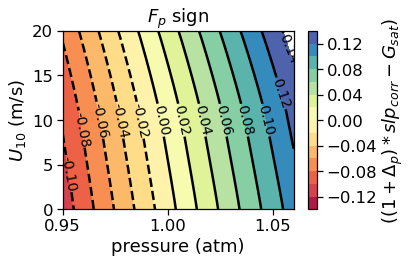

In [81]:
fig, ax = plt.subplots()
z = pressuretermarray
zlevs = np.arange(-0.14, 0.14, 0.02)
contourlevs = np.arange(-0.14, 0.14, 0.02)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "Spectral")#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')

ax.clabel(CS, fmt = '%.2f', colors = 'k', fontsize=14)

ax.set_title(fr"$F_p$ sign")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = fr"$((1+\Delta_p)*slp_{{corr}}-G_{{sat}})$")
plt.tight_layout()
plt.savefig('figures/Fpsigncontour.pdf')

print("Sign is governed by ((1+dP) * slp_corr - Gsat)")

At SP = 33, pt = 0 deg C, pN2Osw = 337.0 natm, and SLP = 1 atm, diffusive component is net out but bubble component is net in.


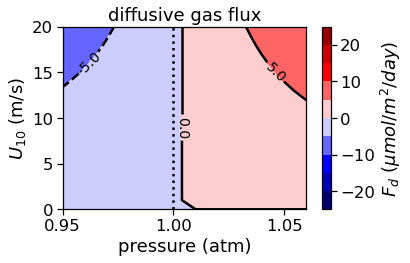

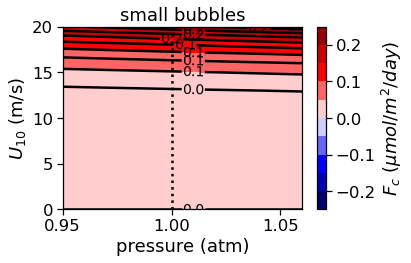

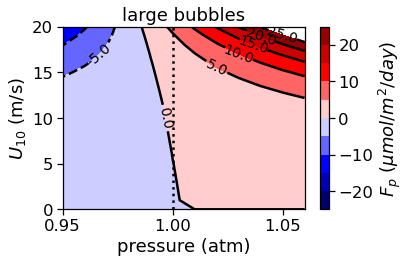

In [82]:
fig, ax = plt.subplots()
z = Fdarray
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.axvline(1, color = "k", linestyle = ":")
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"diffusive gas flux")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = fr"$F_d\ (\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/Fdcontour.pdf')

fig, ax = plt.subplots()
z = Fcarray
zlevs = np.arange(-0.25,0.3,0.05)
contourlevs = np.arange(0,0.25,0.025)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.axvline(1, color = "k", linestyle = ":")
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"small bubbles")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = fr"$F_c\ (\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig('figures/Fccontour.pdf')

fig, ax = plt.subplots()
z = Fparray
zlevs = np.arange(-25,30,5)
contourlevs = np.arange(-25,30,5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = Fcmap)#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.axvline(1, color = "k", linestyle = ":")
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"large bubbles")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = fr"$F_p\ (\mu mol/m^2/day)$")
plt.tight_layout()
plt.savefig("figures/Fpcontour.pdf")

print(f"At SP = {SP}, pt = {pt} deg C, pN2Osw = {pN2O*1e9} natm, and SLP = 1 atm, diffusive component is net out but bubble component is net in.")

Dp = supersaturation due to partially dissolved bubbles - some gas is being driven into the ocean by large bubbles that partially dissolve


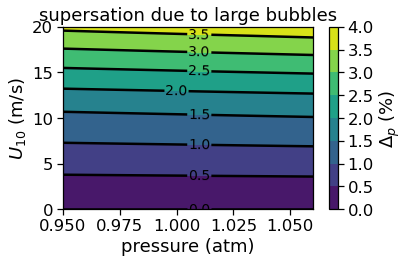

In [83]:
fig, ax = plt.subplots()
z = dParray*100
zlevs = np.arange(0.0,4.5,0.5)
contourlevs = np.arange(0.0,4.5,0.5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "viridis")#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')

ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"supersation due to large bubbles")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = fr"$\Delta_p$ (%)")
plt.tight_layout()
plt.savefig('figures/dPcontour.pdf')

print("Dp = supersaturation due to partially dissolved bubbles - some gas is being driven into the ocean by large bubbles that partially dissolve")

Deq = bubble-induced supersaturation at which the TOTAL gas flux between the ocean and atmosphere is zero - bubble-mediated flux into the ocean is balanced by diffusive flux out of the ocean


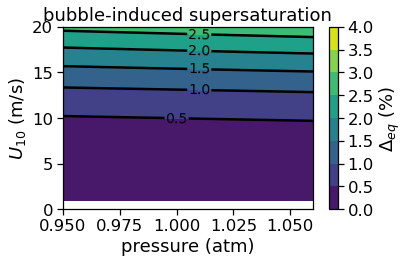

In [84]:
fig, ax = plt.subplots()
z = Deqarray*100
zlevs = np.arange(0.0,4.5,0.5)
contourlevs = np.arange(0.0,4.5,0.5)
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "viridis")#, vmin=0, vmax = 6)
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')

ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_title(fr"bubble-induced supersaturation")
ax.set_xlabel("pressure (atm)")
ax.set_ylabel("$U_{10}$ (m/s)")
cbar = fig.colorbar(cf, label = fr"$\Delta_{{eq}}$ (%)")
plt.tight_layout()
plt.savefig('figures/Deqcontour.pdf')

print("Deq = bubble-induced supersaturation at which the TOTAL gas flux between the ocean and atmosphere is zero - bubble-mediated flux into the ocean is balanced by diffusive flux out of the ocean")

In [75]:
L13(1e-3,20,33,30,gas='N2O',chi_atm=338e-9,
      air_temperature=30, calculate_schmidtair=True, rh = 1.0,
   return_vars = 'rwt')

(6610.181457603511,)

In [76]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(200e-9,20,33,0,slp=1.0,gas='N2O',rh=1.0,chi_atm=338e-9,
                                          air_temperature=20, calculate_schmidtair=True,
                                         return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"],
                                         pressure_mode=True)
F = (Fd+Fc+Fp)*86400*1e6
F

115.34106203201611

In [77]:
L13(1e-3,20,33,30,gas='CO2',chi_atm = 421e-6,air_temperature=30, calculate_schmidtair=True, rh = 1.0,
   return_vars = ('Ks', 'Kb', 'Kc', 'dP'), Ks = 5, Kb = 0.0001, Kc=6e-06, dP = 0.035)

(5, 0.0001, 6e-06, 0.035)

In [78]:
from gasex.airsea import L13
L13(1e-3,20,33,30,gas='CO2',chi_atm = 421e-6,air_temperature=30, calculate_schmidtair=True, rh = 1.0,
   return_vars = ['Ks', 'Kb', 'Kc'], Ks = 5, Kb = 0.0001, Kc=6e-06)

(5, 0.0001, 6e-06)

In [60]:
L13(1e-3,20,33,30,gas='N2O',chi_atm=338e-9,
      air_temperature=30, calculate_schmidtair=True, rh = 1.0,
   return_vars = ['rwt', 'rat'])

(6610.181457603511, 32.865054792160144)

In [61]:
L13(1e-3,20,33,0,gas='Ar', air_temperature=20, calculate_schmidtair=True,
   return_vars = ('Fd', 'Fc', 'Fp', 'Deq', 'Ks', 'Kc', 'ScW', 'Geq', 'Kb', 'ustarw'))

(1.2719060583202534e-06,
 6.047443297438035e-08,
 3.4363386493898977e-06,
 0.03830532696200603,
 7.597356100408138e-05,
 6.48032929429708e-06,
 1324.3253329690244,
 0.01774143006475536,
 0.00019776005348823457,
 0.029028835014260065)

In [62]:
L13(1e-3,20,33,0,gas='Ar', air_temperature=20, calculate_schmidtair=True,
   return_vars = ('Fd', 'Fc', 'Fp', 'Deq', 'Ks', 'Kc', 'ScW', 'Geq', 'Kb', 'ustarw'))

(1.2719060583202534e-06,
 6.047443297438035e-08,
 3.4363386493898977e-06,
 0.03830532696200603,
 7.597356100408138e-05,
 6.48032929429708e-06,
 1324.3253329690244,
 0.01774143006475536,
 0.00019776005348823457,
 0.029028835014260065)

In [286]:
L13unitcheck(1e-3,20,33,0,gas='Ar', air_temperature=20, calculate_schmidtair=True,
   return_vars = ('Fd', 'Fc', 'Fp', 'Deq', 'Ks', 'Kc', 'ScW', 'Geq', 'Kb', 'ustarw'))

(1.2719060583202534e-06 <Unit('mole / meter ** 2 / second')>,
 array([6.0474433e-08]) <Unit('mole / meter ** 2 / second')>,
 3.4363386493898977e-06 <Unit('mole / meter ** 2 / second')>,
 array([0.03830533]) <Unit('dimensionless')>,
 7.597356100408138e-05 <Unit('meter / second')>,
 6.48032929429708e-06 <Unit('mole / meter ** 2 / second')>,
 1324.3253329690244,
 0.01774143006475536 <Unit('mole / meter ** 3')>,
 0.00019776005348823457 <Unit('meter / second')>,
 0.029028835014260065 <Unit('dimensionless')>)

In [287]:
L13(1e-3,20,33,0,gas='Ar', air_temperature=20, calculate_schmidtair=True,
   return_vars = ('Fd', 'Fc', 'Fp', 'Deq', 'Ks', 'Kc', 'ScW', 'Geq', 'Kb', 'ustarw'))

(1.2719060583202534e-06,
 6.047443297438035e-08,
 3.4363386493898977e-06,
 0.03830532696200603,
 7.597356100408138e-05,
 6.48032929429708e-06,
 1324.3253329690244,
 0.01774143006475536,
 0.00019776005348823457,
 0.029028835014260065)

In [288]:
Geq = L13(10e-3,20,33,0,gas='Ar',
                                return_vars = 'Geq')
Geq

(0.01774143006475536,)

In [63]:
%%time
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Deq,) = L13unitcheck(1e-6,j,35,k,gas='Ar',
                                                 return_vars = 'Deq')
        z[k,j] = Deq*100

/Users/colette/anaconda3/envs/py310_oceml/lib/python3.10/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


CPU times: user 8.93 s, sys: 7.61 ms, total: 8.94 s
Wall time: 9.03 s


In [127]:
%%time
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Deq,) = L13(1e-6,x[j],35,y[k],gas='Ar',return_vars = 'Deq')
        z[k,j] = Deq*100

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


CPU times: user 1.18 s, sys: 3.51 ms, total: 1.18 s
Wall time: 1.2 s


/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


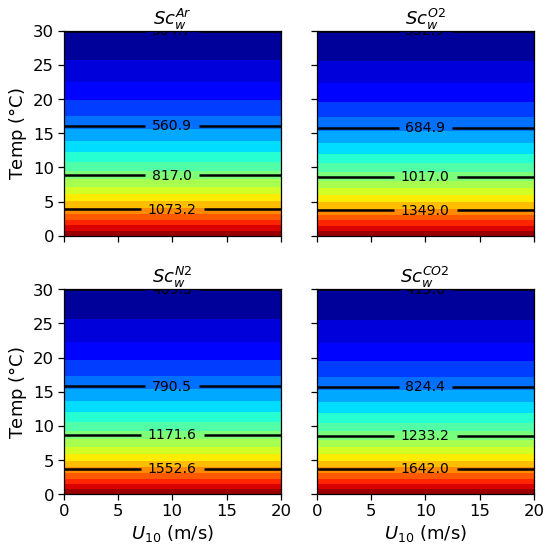

In [128]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (ScW,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                                            return_vars = 'ScW')
            z[k,j] = ScW
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$Sc_w^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


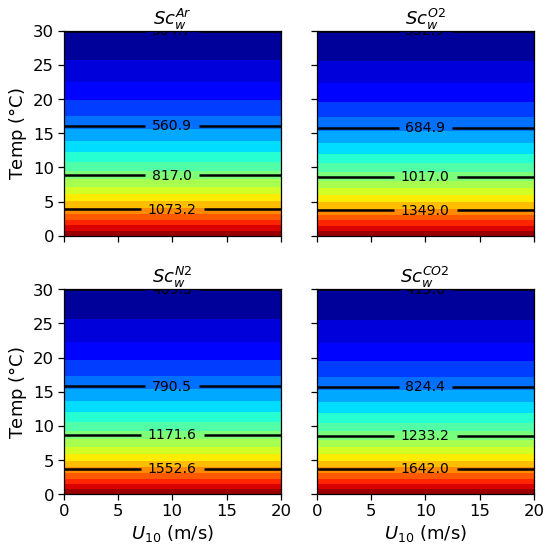

In [129]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (ScW,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                                                 return_vars = 'ScW')
            z[k,j] = ScW
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$Sc_w^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


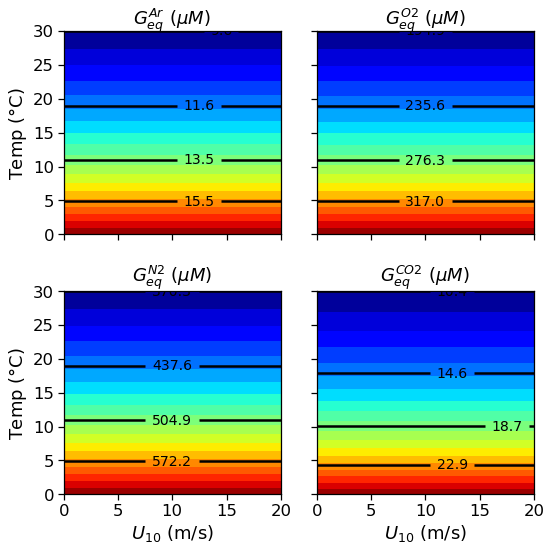

In [123]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (Geq,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                                            return_vars = 'Geq')
            z[k,j] = Geq*1000
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$G_{{eq}}^{{{gases[i]}}}\ (\mu M)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


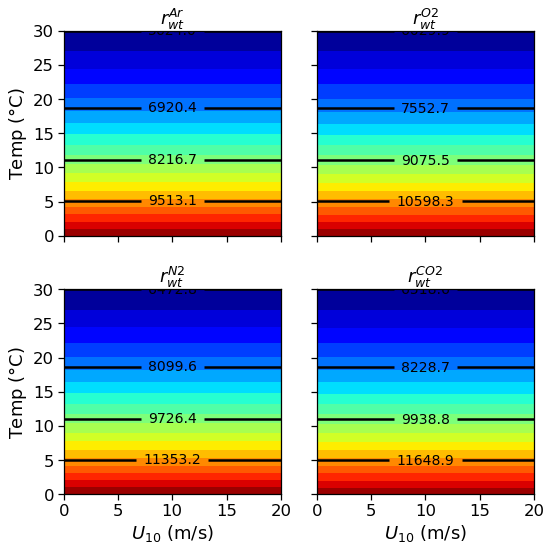

In [124]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (rwt, rat) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                            return_vars = ["rwt","rat"])
            z[k,j] = rwt
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$r_{{wt}}^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


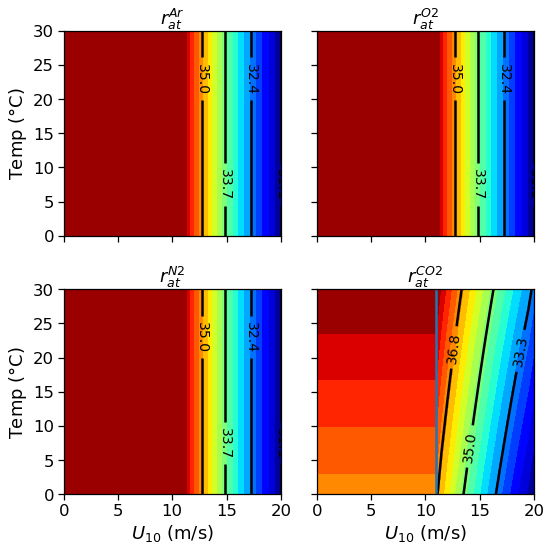

In [125]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (rwt, rat) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                            return_vars = ["rwt","rat"])
            z[k,j] = rat
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$r_{{at}}^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")
    if i==3:
        ax.axvline(11)

plt.tight_layout()

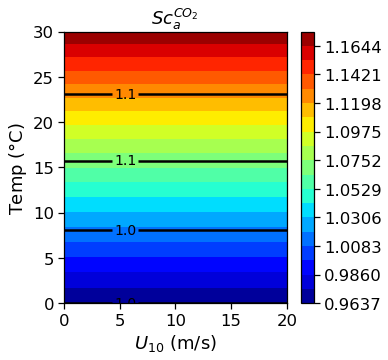

In [126]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        xH2O = xH2O_from_rh(35,y[k],slp=1.0,rh=1.0)
        # Calculate density of air
        rhoa = density(1.0 * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3
        rhoa = rhoa = float(rhoa * units('m3/kg')) # need to non-dimensionalize to drop units
        ScA = air_side_Schmidt_number(y[k], rhoa, gas='CO2', calculate=True)
        #(rwt, rat) = rwtat(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
        z[k,j] = ScA
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{CO_2}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


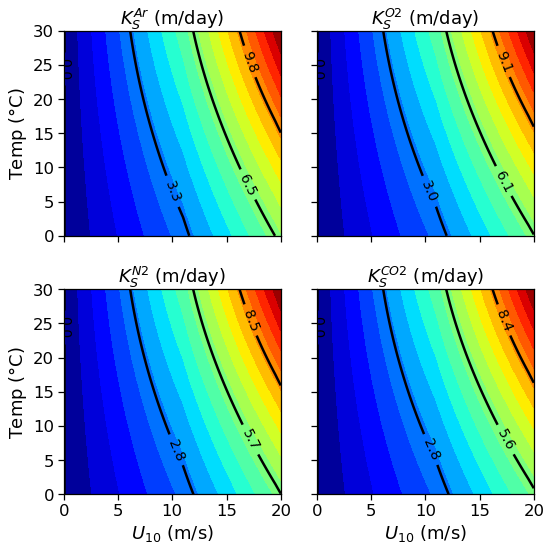

In [127]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (Ks,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                                            return_vars = 'Ks')
            z[k,j] = Ks*86400
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$K_S^{{{gases[i]}}}$ (m/day)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


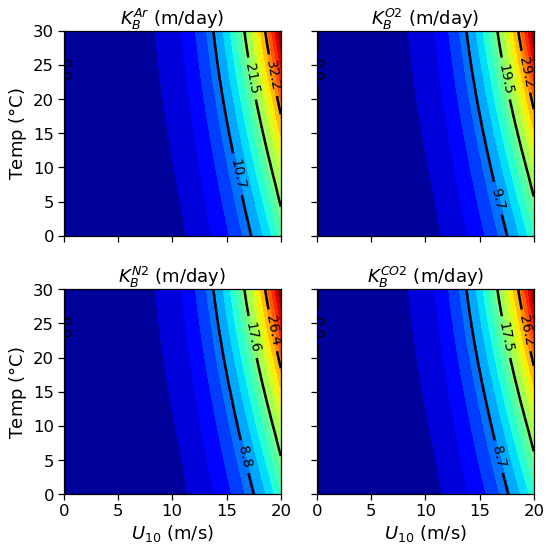

In [128]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (Ks,Kt) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                                            return_vars = ['Ks', 'Kt'])
            z[k,j] = (Kt - Ks)*86400
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$K_B^{{{gases[i]}}}$ (m/day)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


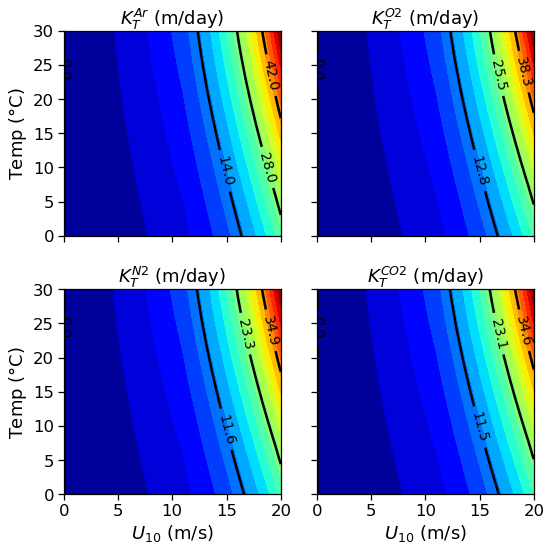

In [129]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (Kt,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                                            return_vars = 'Kt')
            z[k,j] = Kt*86400
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$K_T^{{{gases[i]}}}$ (m/day)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

In [84]:
L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                                        return_vars = ['ScW'])

(428.5259999999996,)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


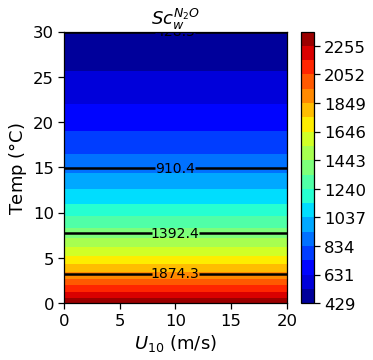

In [130]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (ScW,) = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                                        return_vars = 'ScW')
        z[k,j] = ScW
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_w^{{N_2O}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


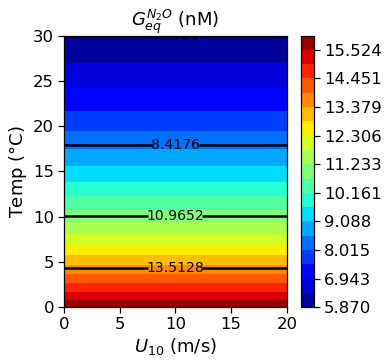

In [131]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Geq,) = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                    return_vars = "Geq")
        z[k,j] = Geq*1e6
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.4f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$G_{{eq}}^{{N_2O}}$ (nM)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


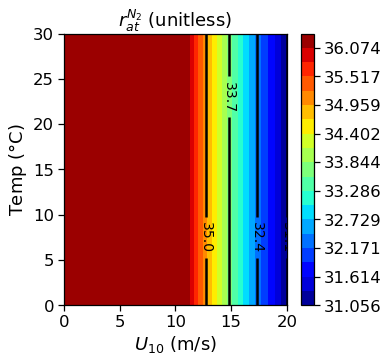

In [133]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rats = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        rwt, rat = L13(1e-6,x[j],35,y[k],gas='N2', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                      return_vars = ["rwt", "rat"])
        rats[k,j] = rat
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 20)
contourlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rats, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rats, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2}}$ (unitless)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


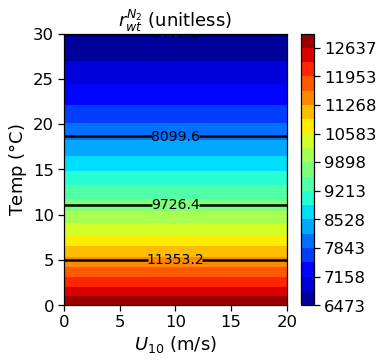

In [134]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rwts = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        rwt, rat = L13(1e-6,x[j],35,y[k],gas='N2', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                      return_vars = ["rwt", "rat"])
        rwts[k,j] = rwt
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 20)
contourlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rwts, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rwts, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{wt}}^{{N_2}}$ (unitless)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


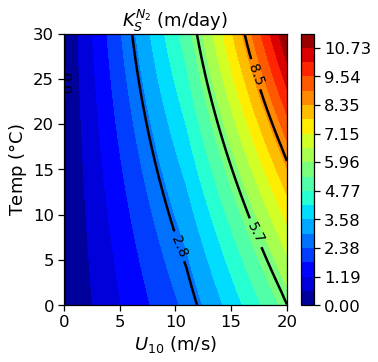

In [135]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Ks,) = L13(1e-6,x[j],35,y[k],gas='N2', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                   return_vars = "Ks")
        z[k,j] = Ks*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_S^{{N_2}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

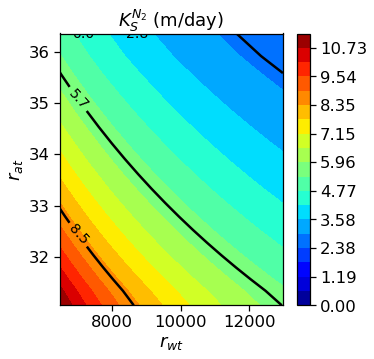

In [136]:
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)

contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(rwts, rats, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(rwts, rats, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$r_{wt}$")
ax.set_ylabel("$r_{at}$")
ax.set_title(fr"$K_S^{{N_2}}$ (m/day)")
cbar = fig.colorbar(cf)

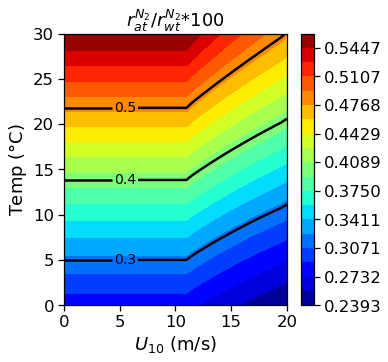

In [137]:
zplot = rats/rwts*100
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 20)
contourlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, zplot, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, zplot, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2}}/r_{{wt}}^{{N_2}}$*100")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

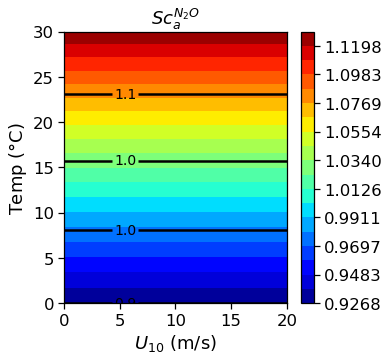

In [138]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        xH2O = xH2O_from_rh(35,y[k],slp=1.0,rh=1.0)
        # Calculate density of air
        rhoa = density(1.0 * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3
        rhoa = rhoa = float(rhoa * units('m3/kg')) # need to non-dimensionalize to drop units
        ScA = air_side_Schmidt_number(y[k], rhoa, gas='N2O', calculate=True)
        z[k,j] = ScA
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{N_2O}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


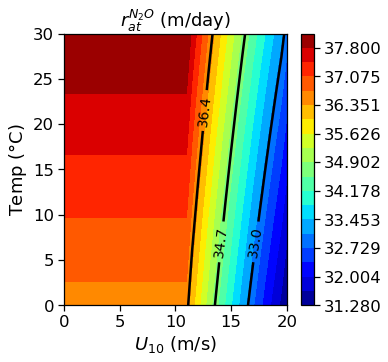

In [136]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rats = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (rat,) = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                   return_vars = "rat")
        rats[k,j] = rat
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 20)
contourlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rats, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rats, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


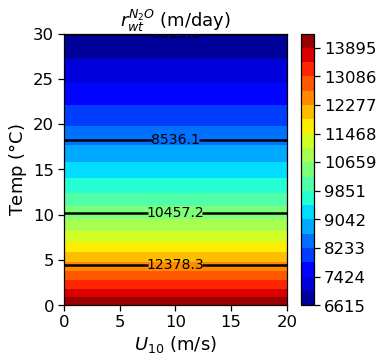

In [137]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rwts = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (rwt,) = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                   return_vars = "rwt")
        rwts[k,j] = rwt
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 20)
contourlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rwts, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rwts, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{wt}}^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


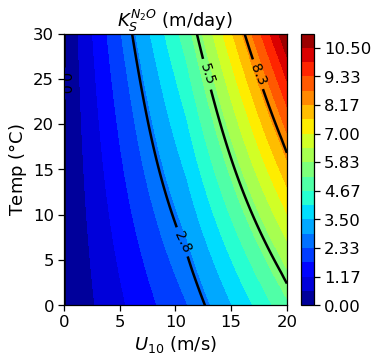

In [138]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Ks,) = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                   return_vars = "Ks")
        z[k,j] = Ks*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_S^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

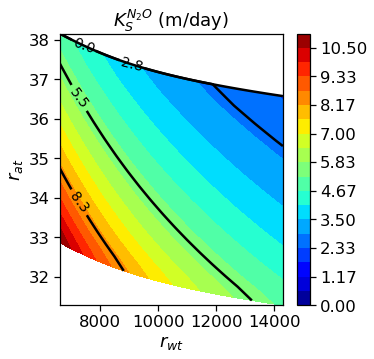

In [139]:
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)

contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(rwts, rats, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(rwts, rats, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$r_{wt}$")
ax.set_ylabel("$r_{at}$")
ax.set_title(fr"$K_S^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)

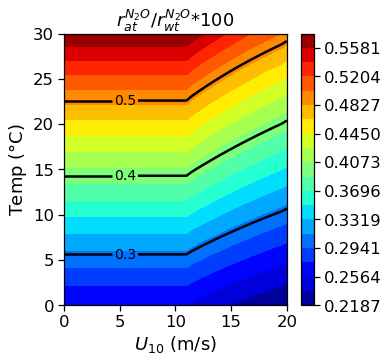

In [140]:
zplot = rats/rwts*100
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 20)
contourlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, zplot, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, zplot, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2O}}/r_{{wt}}^{{N_2O}}$*100")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


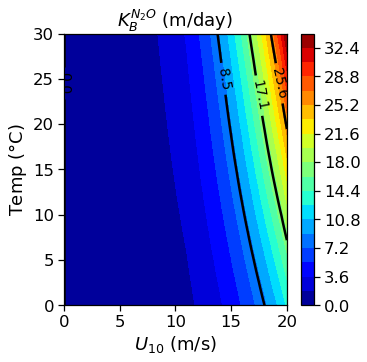

In [141]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Kb,)= L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                    return_vars = ["Kb"])
        z[k,j] = (Kb)*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_B^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


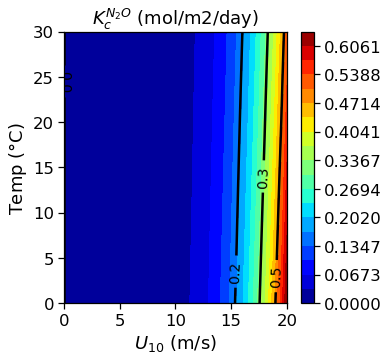

In [144]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Kc,) = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True,
                   return_vars = ["Kc"])
        z[k,j] = Kc*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_c^{{N_2O}}$ (mol/m2/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


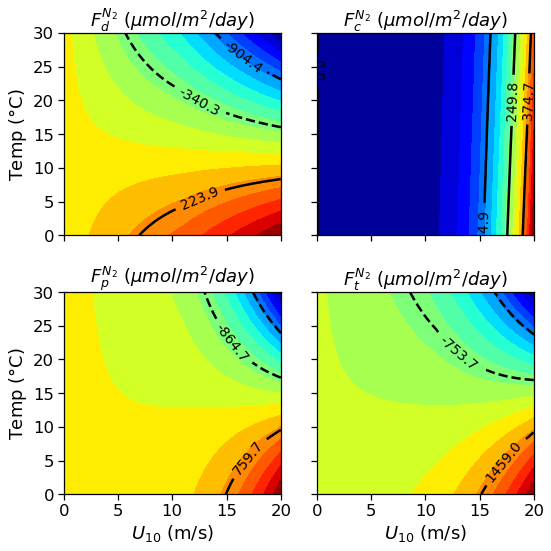

In [145]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        (Fd,Fc,Fp) = L13(0.5,x[j],35,y[k],gas='N2', chi_atm = None, air_temperature=y[k], calculate_schmidtair=True,
                        return_vars = ("Fd","Fc","Fp"))
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{N_2}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


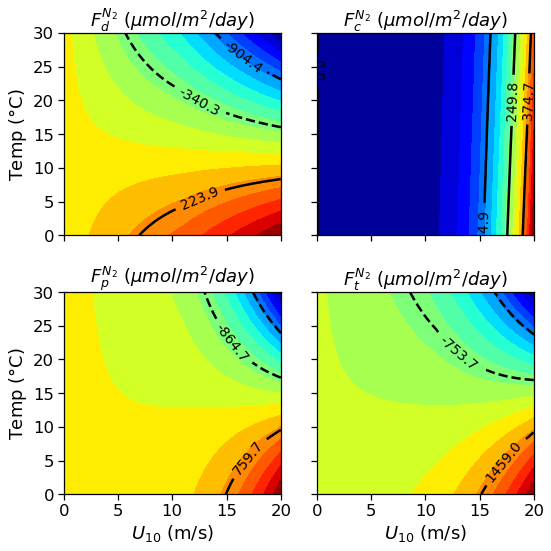

In [146]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp = L13(0.5,x[j],35,y[k],gas='N2', chi_atm = None, air_temperature=y[k], calculate_schmidtair=True,
                      return_vars = ("Fd","Fc","Fp"))
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{N_2}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


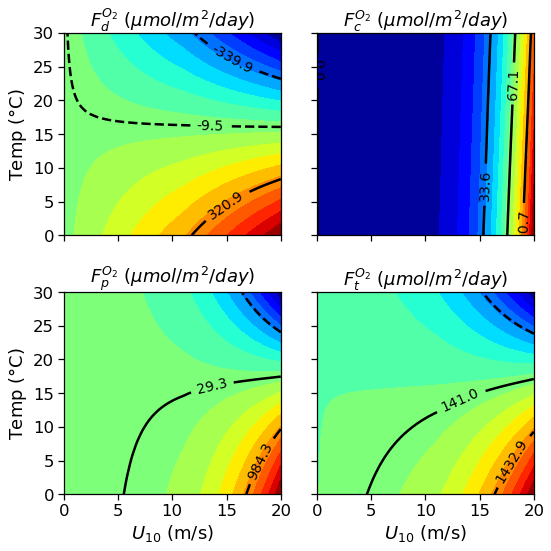

In [147]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        (Fd,Fc,Fp)= L13(0.25,x[j],35,y[k],gas='O2', chi_atm = None, air_temperature=y[k], calculate_schmidtair=True,
                       return_vars = ("Fd","Fc","Fp"))
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{O_2}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


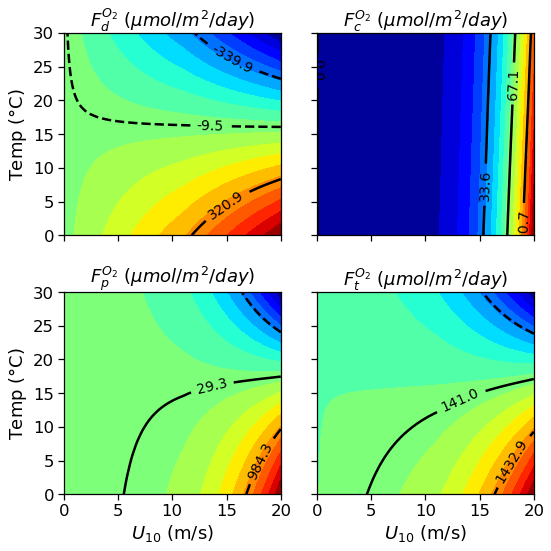

In [148]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp = L13(0.25,x[j],35,y[k],gas='O2', chi_atm = None, air_temperature=y[k], calculate_schmidtair=True,
                      return_vars = ("Fd","Fc","Fp"))
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{O_2}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


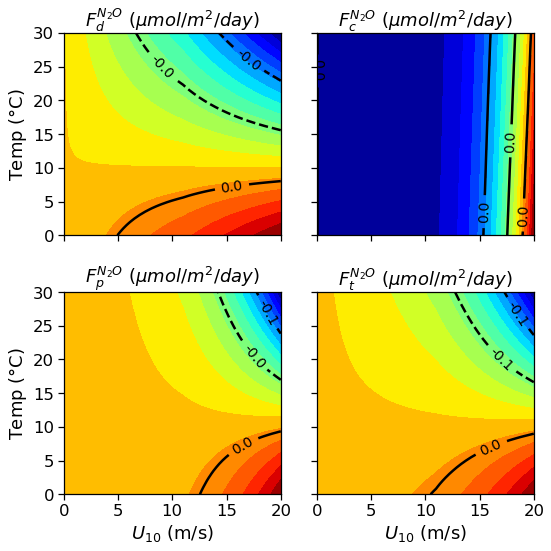

In [149]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        (Fd,Fc,Fp) = L13(11e-6,x[j],35,y[k],gas='N2O', chi_atm = 338e-9, air_temperature=y[k], calculate_schmidtair=True,
                                        return_vars = ("Fd","Fc","Fp"))
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{N_2O}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

In [156]:
type(Fd)

numpy.float64

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


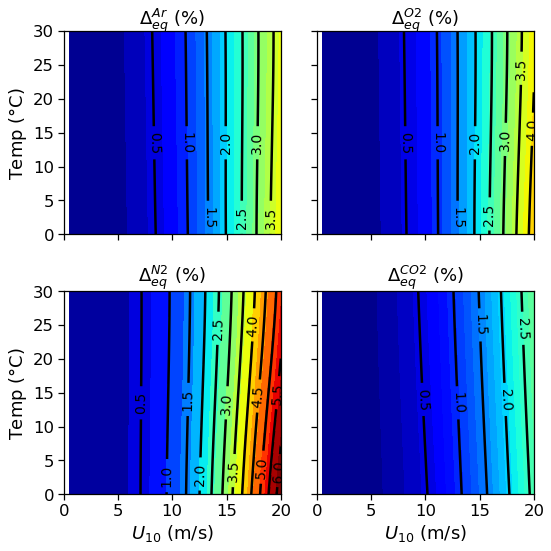

In [150]:
# DON'T CALCULATE AIR_SIDE SCHMIDT
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (Deq,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i],
                        return_vars = "Deq")
            z[k,j] = Deq*100
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(0, 6, 13)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$\Delta^{{{gases[i]}}}_{{eq}}$ (%)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


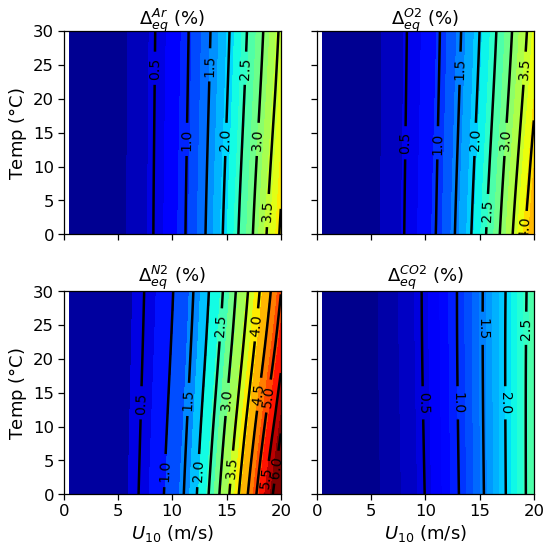

In [151]:
# CALCULATE AIR_SIDE SCHMIDT
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (Deq,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_schmidtair=True,
                                            return_vars = "Deq")
            z[k,j] = Deq*100
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(0, 6, 13)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$\Delta^{{{gases[i]}}}_{{eq}}$ (%)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()
plt.savefig('figures/Deq.png', dpi=300)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7194/364099836.py:141: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


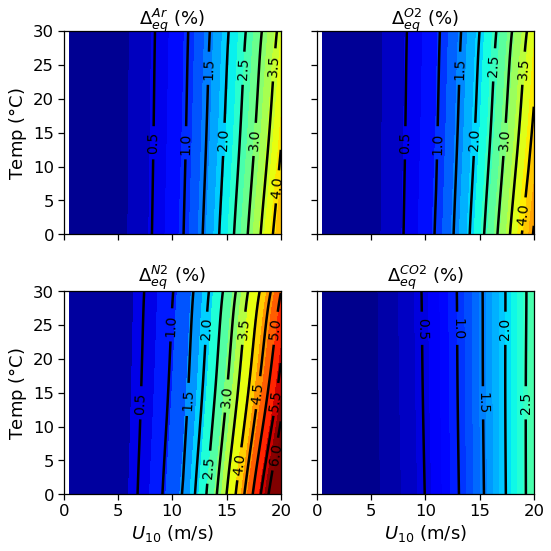

In [163]:
# CALCULATE AIR_SIDE SCHMIDT, CALCULATE WATER-SIDE SCHMIDT WITH W92
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (Deq,) = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k],
                      calculate_schmidtair=True,schmidt_parameterization="W92", return_vars = "Deq")
            z[k,j] = Deq*100
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(0, 6, 13)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$\Delta^{{{gases[i]}}}_{{eq}}$ (%)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()
plt.savefig('figures/DeqW92.png', dpi=300)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3572/1737233637.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


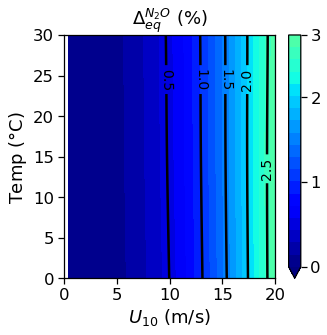

In [152]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        (Deq,) = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_schmidtair=True, schmidt_parameterization="W92",
                    return_vars = "Deq")
        z[k,j] = Deq*100
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(0, 6, 13)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$\Delta^{{N_2O}}_{{eq}}$ (%)")
cbar = fig.colorbar(cf)
cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar
plt.tight_layout()
plt.savefig('figures/N2ODeqW92.png', dpi=300)

In [165]:
L13(200e-6,10,33,30,slp=0.94,gas='N2O',rh=1.0,chi_atm=338e-9, air_temperature=30, calculate_schmidtair=False)

(-9.89205443233927e-09,
 5.645717236469257e-14,
 -5.973101637922809e-09,
 0.005067556370286604,
 5.07834146035633e-05)

In [154]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(11e-6,20,33,20,slp=1.0,gas='N2O',rh=1.0,chi_atm=338e-9,
                                          air_temperature=20, calculate_schmidtair=True,
                                         return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
F = Fd+Fc+Fp
F.to('umol/(m2 day)')

-98.73433923832461 <Unit('micromole / day / meter ** 2')>

In [155]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(200e-9,20,33,0,slp=1.0,gas='N2O',rh=1.0,chi_atm=338e-9,
                                          air_temperature=20, calculate_schmidtair=True,
                                         return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"],
                                         pressure_mode=True)
F = Fd+Fc+Fp
F.to('umol/(m2 day)')

115.34106203201611 <Unit('micromole / day / meter ** 2')>

In [156]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(200e-9,20,33,0,slp=1.0,gas='N2O',rh=1.0,chi_atm=338e-9,
                                          air_temperature=20, calculate_schmidtair=True,
                                         return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"],
                                         pressure_mode=True)
F = (Fd+Fc+Fp)*86400*1e6
F

115.34106203201611

In [157]:
L13(10e-6,10,33,30,slp=0.94,gas='N2O',rh=1.0,chi_atm=338e-9, air_temperature=None, calculate_schmidtair=False)

(-2.5945318166186584e-10,
 7.246503156694889e-14,
 -1.7293072087069374e-10,
 0.005817659836006579,
 5.417603612185079e-05)

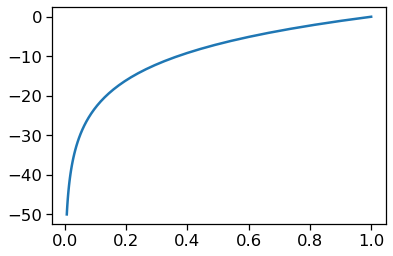

In [158]:
z = np.linspace(-50,0)
z0 = 10
Cb = np.exp(z/z0)

plt.plot(Cb, z)

In [63]:
# functions to compare L13 output with N2O flux from Kelly et al. (2021),
# calculated based on Wanninkhof 2014
def calculate_s(salt, temp):
    """
    Source: Weiss and Price, 1980 (Table 2).
    Inputs: salinity (PSU); temperature (degrees celsius)
    Ouputs: N2O saturation (nmol/L)
    """
    A1 = -62.7062 # constants from Table 2 in Weiss and Price
    A2 = 97.3066
    A3 = 24.1406
    B1 = -0.05842
    B2 = 0.033193
    B3 = -0.0051313
    tempK = 273.15 + temp # calculate temperature in Kelvins
    lns = A1 + A2*(100/tempK)+A3*np.log(tempK/100)+salt*(B1+B2*(tempK/100)+B3*(tempK/100)**2)
    s = np.exp(lns) # N2O saturation in mol/L/atm
    return s

def calculate_schmidt(temp):
    """
    Source: Weiss and Price, 1980 (Table 2).
    Inputs: salinity (PSU); temperature (degrees celsius)
    Ouputs: N2O saturation (nmol/L)
    """
    A = 2356.2 # constants from Table 1 in Wanninkhof, 2014
    B = -166.38
    C = 6.3952
    D = -0.13422
    E = 0.0011506
    Sc = A + B*temp + C*temp**2 + D*temp**3 + E*temp**4 # UNITLESS
    return Sc

def calculate_k(U10, Sc):
    # U10 = windspeed, m/s
    # Sc = temperature-dependent Schmidt number, unitless
    # k = piston velocity, cm/h
    scaling = 0.251 # (cm/h)(m/s)^-2 , Wanninkhof, 2014
    k = scaling * U10**2 * 1/(np.sqrt(Sc/660))
    return k
def calculate_flux(k, s, dpN2O):
    # k = piston velocity, cm/h
    # s = N2O solubility, mol/L/atm
    # dpN2O = ocean-atmosphere pressure gradient, atm
    # s_transformed = N2O solubility, mol/cm3/atm
    s_transformed = s*0.001 # mol/cm3/atm
    F = k * s_transformed * dpN2O * 10000 # mol/m2/h
    
    
    F1 = F * 8760 # mol N2O/m2/year
    F2 = F1 * 44.013 # g N2O/m2/year
    F3 = F1*10**6/365 # umol N2O/m2/day
    return F2, F3

In [64]:
n2o = pd.read_excel('n2otests/surface_N2O.xlsx')
n2o.columns

Index(['Cruise', 'Station', 'DateCTD', 'Latitude [N]', 'Longitude [E]',
       'Longitude [degrees_east]', 'Month', 'Year_int', 'Month_int', 'lat_int',
       'lon_int', 'CTD_Pressure [db]', 'CTD_Depth [m]', 'Sigma_theta [kg/m3]',
       'Salinity [psu]', 'Temperature [C]', 'Temperature [K]',
       'Oxygen [umol/L]', 'N2O_mean', 'N2O_std'],
      dtype='object')

In [65]:
# read in data from Kelly et al. (2021)
n2o = pd.read_excel('n2otests/surface_N2O.xlsx')
NOAA = pd.read_csv('n2otests/mlo_N2O_MM.dat', delimiter=' ', skiprows=53,header=None)
NOAA = NOAA[[0,7,11]]
NOAA = NOAA.rename(columns = {0:'YYYY', 7:'MM', 11:'XN2Oa'})
ERA5 = xr.open_dataset('n2otests/ERA5_monthly_mean.nc', decode_cf=True)

msl = ERA5['msl'][:]
u10 = ERA5['u10'][:]
v10 = ERA5['v10'][:]

surface_msl = []
surface_U10 = []
surface_XN2Oa = []

for i in list(range(len(n2o))):
    month = n2o['Month'].iloc[i]
    lat = n2o['lat_int'].iloc[i]
    lon = n2o['lon_int'].iloc[i]
    year_int = n2o['Year_int'].iloc[i]
    month_int = n2o['Month_int'].iloc[i]
    msl_i = float(msl.loc[month, lat, lon].values)
    msl_i = msl_i*9.8692e-6 # convert Pa to ATM
    surface_msl.append(msl_i)
    u10_i = float(u10.loc[month, lat, lon].values)
    v10_i = float(v10.loc[month, lat, lon].values)
    U10_i = np.sqrt(u10_i**2 + v10_i**2) # wind speed in m/s
    surface_U10.append(U10_i)
    XN2Oa_i = float(NOAA[(NOAA.YYYY==year_int)&(NOAA.MM==month_int)].XN2Oa)
    surface_XN2Oa.append(XN2Oa_i)
    
n2o['sealevelpressure_atm'] = surface_msl # ATM
n2o['windspeed_m_s'] = surface_U10 # m/s
n2o['s_mol_L_atm'] = calculate_s(n2o['Salinity [psu]'],
n2o['Temperature [C]'])
n2o['Sc'] = calculate_schmidt(n2o['Temperature [C]'])
n2o['XN2Oa_ppb'] = surface_XN2Oa
n2o['XN2Ow_ppb'] = n2o.N2O_mean/(n2o.s_mol_L_atm*n2o.sealevelpressure_atm)
n2o['dXN2O_ppb'] = n2o['XN2Ow_ppb'] - n2o['XN2Oa_ppb']
n2o['dpN2O_atm'] = n2o['dXN2O_ppb']*10**-9*n2o['sealevelpressure_atm']
n2o['k_cm_h'] = calculate_k(n2o['windspeed_m_s'], n2o['Sc'])
n2o['F_g_m2_year'], n2o['F_umol_m2_day'] = calculate_flux(n2o['k_cm_h'],n2o['s_mol_L_atm'], n2o['dpN2O_atm'] )
n2o['F_umol_m2_day'] = -n2o['F_umol_m2_day']
n2o['F_g_m2_year'] = -n2o['F_g_m2_year']
# add potential temperature for L13 calculation
n2o['pref'] = 0
n2o["SA"] = gsw.SA_from_SP(n2o['Salinity [psu]'],n2o['CTD_Pressure [db]'],n2o['Longitude [E]'],n2o['Latitude [N]'])
n2o['pt'] = gsw.pt_from_t(n2o["SA"],n2o['Temperature [C]'],n2o['CTD_Pressure [db]'], n2o['pref'])

# add concentration in mol/m3 for L13 calculation
n2o["C"] = n2o.N2O_mean*1e-6

# convert XN2O from ppb to mol/mol for L13 calculation
n2o['XN2Oa'] = n2o.XN2Oa_ppb*1e-9

In [66]:
n2ods = n2o.set_index(["Latitude [N]", "Longitude [E]"]).to_xarray()
type(n2ods.C)
n2o[['Cruise','Station','N2O_mean','dXN2O_ppb','windspeed_m_s','Salinity [psu]','pt','F_umol_m2_day']]

,Cruise,Station,N2O_mean,dXN2O_ppb,windspeed_m_s,Salinity [psu],pt,F_umol_m2_day
0,SR1805,PS2,11.061920,244.403181,2.539497,34.1808,27.946305,-2.155207
1,SR1805,PS3,67.495099,2847.817819,1.454974,34.5530,24.231245,-8.320750
2,SR1805,T1,8.559563,119.694796,5.310382,33.6533,28.510086,-4.622334
3,SR1805,T2,10.257601,206.663510,3.953975,33.7303,28.326968,-4.424881
4,SR1805,T3,10.355202,217.993144,2.685918,33.7075,28.766319,-2.152224
5,SR1805,T4,10.892172,225.509236,2.315721,34.4564,27.267452,-1.654242
6,SR1805,T5,11.695256,262.851990,2.847984,34.3444,27.046679,-2.919134
7,SR1805,T6,12.715445,308.481924,2.847984,34.3939,26.677283,-3.428361
8,TN278,BB1,11.453757,215.215418,6.193055,34.6520,24.285235,-11.386204
9,TN278,BB2,5.917854,-28.563552,4.771803,33.8684,26.657477,0.894122


In [67]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(n2ods.C,n2ods.windspeed_m_s,n2ods['Salinity [psu]'],n2ods.pt,
                      slp=n2ods.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2ods['XN2Oa'], air_temperature=n2ods.pt,
                                 calculate_schmidtair=True, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
for param in (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq):
    print(type(param))
    
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=n2o.pt,
                                calculate_schmidtair=True, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
for param in (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq):
    print(type(param))

C = np.array(n2o.C)
u10 = np.array(n2o.windspeed_m_s)
S = np.array(n2o['Salinity [psu]'])
pt = np.array(n2o.pt)
P = np.array(n2o.sealevelpressure_atm)
X = np.array(n2o['XN2Oa'])

Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(C,u10,S,pt,
                      slp=P,gas='N2O',rh=1.0,chi_atm=X, air_temperature=pt,
                                calculate_schmidtair=True, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
for param in (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq):
    print(type(param))

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [68]:
C = np.array(n2o.C)
u10 = np.array(n2o.windspeed_m_s)
S = np.array(n2o['Salinity [psu]'])
pt = np.array(n2o.pt)
P = np.array(n2o.sealevelpressure_atm)
X = np.array(n2o['XN2Oa'])

In [69]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=n2o.pt,
                                calculate_schmidtair=True, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])

In [70]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=n2o.pt,
                                         calculate_schmidtair=True, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
F1 = Fd+Fc+Fp
F1.to('umol/(m2 day)')

Magnitude,[-5.760403555364913 -36.053561833312315 -7.116207673721338 -8.151311223404685 -5.506315616214258 -4.8297306332524625 -7.013986953558849 -8.181975941369735 -15.006115073063016 0.7758414427238429]
Units,micromole/(day meter2)


In [71]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=None,
                                         calculate_schmidtair=False, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
F2 = Fd+Fc+Fp
F2.to('umol/(m2 day)')

Magnitude,[-5.949911716508294 -36.879573208691845 -7.406509870658633 -8.451822610175208 -5.699559487380317 -4.978348605790168 -7.233620057903232 -8.431005064493721 -15.462529028983846 0.8032417342003368]
Units,micromole/(day meter2)


In [72]:
n2o['F_bubbles_Sca'] = F1.to('umol/(m2 day)')
n2o['F_bubbles_only'] = F2.to('umol/(m2 day)')

In [73]:
n2o[['Cruise','Station','N2O_mean','dXN2O_ppb','windspeed_m_s','F_umol_m2_day','F_bubbles_Sca','F_bubbles_only']]

,Cruise,Station,N2O_mean,dXN2O_ppb,windspeed_m_s,F_umol_m2_day,F_bubbles_Sca,F_bubbles_only
0,SR1805,PS2,11.061920,244.403181,2.539497,-2.155207,-5.760404,-5.949912
1,SR1805,PS3,67.495099,2847.817819,1.454974,-8.320750,-36.053562,-36.879573
2,SR1805,T1,8.559563,119.694796,5.310382,-4.622334,-7.116208,-7.406510
3,SR1805,T2,10.257601,206.663510,3.953975,-4.424881,-8.151311,-8.451823
4,SR1805,T3,10.355202,217.993144,2.685918,-2.152224,-5.506316,-5.699559
5,SR1805,T4,10.892172,225.509236,2.315721,-1.654242,-4.829731,-4.978349
6,SR1805,T5,11.695256,262.851990,2.847984,-2.919134,-7.013987,-7.233620
7,SR1805,T6,12.715445,308.481924,2.847984,-3.428361,-8.181976,-8.431005
8,TN278,BB1,11.453757,215.215418,6.193055,-11.386204,-15.006115,-15.462529
9,TN278,BB2,5.917854,-28.563552,4.771803,0.894122,0.775841,0.803242


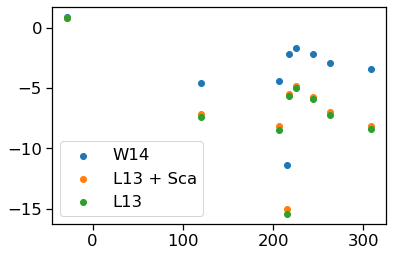

In [74]:
plotdf = n2o[n2o.dXN2O_ppb < 1000]
fig, ax = plt.subplots()
ax.scatter(plotdf.dXN2O_ppb, plotdf.F_umol_m2_day, label = "W14")
ax.scatter(plotdf.dXN2O_ppb, plotdf.F_bubbles_Sca, label = "L13 + Sca")
ax.scatter(plotdf.dXN2O_ppb, plotdf.F_bubbles_only, label = "L13")
ax.legend()

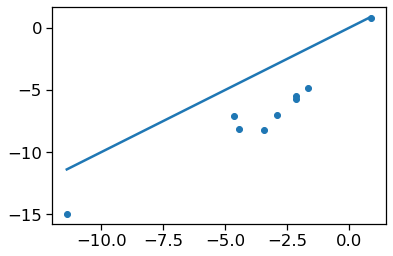

In [75]:
fig, ax = plt.subplots()
ax.scatter(plotdf.F_umol_m2_day, plotdf.F_bubbles_Sca)
ax.plot(np.linspace(plotdf.F_umol_m2_day.min(), plotdf.F_umol_m2_day.max()),
       np.linspace(plotdf.F_umol_m2_day.min(), plotdf.F_umol_m2_day.max()))

In [76]:
# read in S04P data
s04 = pd.read_csv('n2otests/s04.csv')
# set up datetime column in S04P data to match with atmospheric N2O - eventually want to put this in compiledata.py?
s04["date"] = s04.DATE.astype('int').astype('str')
s04["hour"] = s04.TIME // 100
s04["hour"] = s04["hour"].astype('int').astype('str').str.zfill(2)
s04["minute"] = s04.TIME % 100
s04["minute"] = s04["minute"].astype('int').astype('str').str.zfill(2)
s04['datetime'] = s04["date"] + " " + s04["hour"] + ":" + s04["minute"]
s04['t'] = pd.to_datetime(s04['datetime'], format='%Y%m%d %H:%M')
# create timedelta variable, referenced to earliest Argo sample time
s04['timedelta'] = (s04['t'] - s04['t'].min())  / np.timedelta64(1,'D')# convert timestamps to floats for interpolation


# zonal mean atmospheric N2O
zonal = pd.read_csv(f"n2otests/n2o_mm_zonal_updated.csv",
                   parse_dates = ["t"]) # parse dates to attach to S04 data
# want atmospheric N2O data from southernmost bin
band = [-90,-45]
# select data from southernmost bin
atmsubset = pd.DataFrame(zonal[['year', 'month', 'day', 't', f"bin{band[0]}-{band[1]}"]]).rename(columns = {
            f"bin{band[0]}-{band[1]}":'n2o_atm'})
# create numeric timedelta for interpolation, referenced to earliest Argo sample time
atmsubset['timedelta'] = (atmsubset.t - s04['t'].min())  / np.timedelta64(1,'D')
# select atmospheric data from time period of argo data
atmsubset = atmsubset[atmsubset.timedelta>-30] # choose 30 so we can interpolate through 0

# interpolation
x = np.array(atmsubset.timedelta)
y = np.array(atmsubset.n2o_atm)
s04['n2o_atm'] = s04['N2Osol'] # create another variable with the same coords and N2Osol
# np.interp: 1D linear interpolation for monotonically increasing sample points
s04['n2o_atm'] = np.interp(s04['timedelta'][:].values, x, y)
s04['n2o_atm']

0       329.483355
1       329.483355
2       329.483355
3       329.483355
4       329.483355
           ...    
4069    329.486096
4070    329.486096
4071    329.486096
4072    329.486096
4073    329.486096
Name: n2o_atm, Length: 4074, dtype: float64

In [77]:
# figure out what years of ERA5 data we need
print(s04.t.min(), s04.t.max())

2018-01-11 08:16:00 2018-05-09 01:51:00


In [78]:
# read in ERA5 sea level pressure data
fname = "n2otests/2018_mean_sea_level_pressure.nc"
era = xr.open_dataset(fname)
era

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 241, time: 1460)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-03 21:33:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [79]:
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [80]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [81]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
msl_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5

    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    msl = eratemp['msl'][:].values/101325.0 # convert Pa to Atm
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), msl, method="nearest")
    
    msl_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [82]:
# read in ERA5 u-component wind speed data
fname = "n2otests/2018_10m_u_component_of_wind.nc"
era = xr.open_dataset(fname)

In [83]:
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [84]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [85]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
u10_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    u10 = eratemp['u10'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), u10, method="nearest")
    
    u10_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [86]:
u10_interpolated

array([  3.89150953,   1.54609251,   4.03170252,   6.62066603,
         7.44545031,   9.52480888,   6.40065527,  10.74254227,
         1.53585958,   4.54949522,   9.47057343,  -0.1014297 ,
        -1.34065306,   8.74504852,  10.54197311,   8.97836304,
         7.36051607,   5.7754159 ,  -6.57997894,   4.93118811,
        11.00450897,  11.40666771,  -8.68082619, -12.42612457,
        -2.51336145,  -6.39066696,   7.80053759,   6.04863787,
        -8.9346056 , -10.77246284,   6.89593554,   4.08696079,
         8.18018341,  -7.37304068,  -7.09572506,  11.39950371,
        -6.18395948,  -3.39238119,   8.16278839,  -1.44298363,
         2.72903395,   5.54824162,   6.61759615,   5.5748477 ,
        11.22042656,   9.84510231,   4.68764162,   4.56177473,
         5.73755312,   4.5525651 ,  -3.72700214,  -5.33256912,
        -5.96190214,  -3.53973722,  -1.2946043 ,  -0.71336663,
         2.6707058 ,   5.08980083,   8.91901016,   8.92412758,
         7.36256266,   6.59099054,   6.9624505 ,  10.41

In [87]:
# read in ERA5 v-component wind speed data
fname = "n2otests/2018_10m_v_component_of_wind.nc"
era = xr.open_dataset(fname)
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

era.latitude.max()

<xarray.DataArray 'latitude' ()>
array(-30.)

In [88]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [89]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
v10_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    v10 = eratemp['v10'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), v10, method="nearest")
    
    v10_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [90]:
v10_interpolated

array([  5.32538271,   4.1496172 ,   4.50214815,   3.39291644,
         5.02746916,   3.22509193,   8.53093243,   2.55677223,
         6.25090075,   4.54187012,   7.28068876,   3.9688828 ,
         8.2816782 ,   1.50116515,  -1.20389009,   6.39092016,
        -2.24758077,  -3.77091241,  -3.96852803,   9.17442608,
        -0.21779609,   4.77225637,  -1.37469411,   2.21417189,
        -6.53257179, -10.23563671,   2.76332569,   2.15558195,
        -1.37866616,   3.62230992,   3.81198168, -11.1899538 ,
         1.28666735,  -5.16117573,  -4.2723999 ,   4.26878262,
        -0.78581786,  -1.2426188 ,   4.84574175,   0.92519903,
         3.44753408,   5.30452871,   7.01256657,   5.45944357,
         3.45051312,   3.35915279,  -4.08272839,  -5.44617939,
        -2.74410319,  -2.25353885,  -3.60805297,  -1.89802861,
         4.3293581 ,   2.38696146,  -5.01917076,  -9.4024725 ,
        -4.82453346,   5.09499598,   1.82291198,  -1.10061336,
        -6.1949358 ,  -6.40943336, -10.53057194,  -6.89

In [91]:
# read in ERA5 2m air temperature
fname = "n2otests/2018_2m_temperature.nc"
era = xr.open_dataset(fname)
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [92]:
era.t2m

<xarray.DataArray 't2m' (time: 1460, latitude: 181, longitude: 1440)>
[380534400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -45.0 -45.25 -45.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [93]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [94]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
t2m_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    t2m = eratemp['t2m'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), t2m, method="nearest")
    
    t2m_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

t2m_interpolated = t2m_interpolated - 273.15

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [95]:
t2m_interpolated

array([-3.38257446e+00, -2.66388550e+00, -2.37750854e+00, -3.03494873e+00,
       -2.97009888e+00, -2.88904419e+00, -4.19129028e+00, -2.72333374e+00,
       -3.68695679e+00, -4.06522217e+00, -1.96683350e+00, -3.48883667e+00,
       -5.67908325e+00, -3.26367798e+00, -2.11453857e+00, -5.24860229e+00,
       -1.27698364e+00, -1.48770752e+00, -2.52161255e+00, -2.46936646e+00,
       -2.02808228e+00, -5.02524414e+00, -1.06935791e+01, -5.54398193e+00,
       -1.13468018e+00, -1.00501099e+00, -2.17938843e+00, -1.87677612e+00,
       -2.11813965e+00, -7.50369873e+00, -2.06049194e+00, -1.15088501e+00,
       -2.34146729e+00, -9.99609375e-01, -1.57596436e+00, -3.88870850e+00,
       -1.08196777e+01, -1.17400879e+01, -1.11487427e+00, -1.21525635e+01,
       -1.20048584e+01, -1.15041260e+01, -1.14356750e+01, -1.14158691e+01,
       -3.92584229e-01, -5.42089844e-01, -1.43729248e+00, -9.68969727e-01,
       -1.01401367e+00, -1.43009033e+00, -1.43729248e+00, -1.48770752e+00,
       -2.07669678e+00, -

In [96]:
# read in ERA5 dewpoint temperature
fname = "n2otests/2018_2m_dewpoint_temperature.nc"
era = xr.open_dataset(fname)
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [97]:
era.d2m

<xarray.DataArray 'd2m' (time: 1460, latitude: 181, longitude: 1440)>
[380534400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -45.0 -45.25 -45.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Attributes:
    units:      K
    long_name:  2 metre dewpoint temperature

In [98]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [99]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
d2m_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    d2m = eratemp['d2m'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), d2m, method="nearest")
    
    d2m_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

d2m_interpolated = d2m_interpolated - 273.15

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [100]:
d2m_interpolated

array([-1.12461304e+01, -1.09034180e+01, -9.49121704e+00, -9.24417725e+00,
       -7.91641846e+00, -7.51636353e+00, -1.05607361e+01, -6.11371460e+00,
       -7.83194580e+00, -9.67612305e+00, -7.82556763e+00, -6.01965942e+00,
       -1.01606812e+01, -9.42746582e+00, -9.14694824e+00, -9.58685913e+00,
       -2.74893799e+00, -4.00494995e+00, -4.96927490e+00, -4.98682251e+00,
       -4.71903076e+00, -1.01750244e+01, -1.24527344e+01, -7.05411377e+00,
       -1.73840942e+00, -2.14325562e+00, -5.88419189e+00, -4.19144287e+00,
       -2.92270508e+00, -9.05768433e+00, -4.68717041e+00, -2.37598267e+00,
       -7.33466187e+00, -1.79419556e+00, -2.32495728e+00, -8.78671875e+00,
       -1.30902771e+01, -1.39637512e+01, -2.16718140e+00, -1.43160156e+01,
       -1.42681946e+01, -1.37023376e+01, -1.38155273e+01, -1.37501587e+01,
       -1.46427002e+00, -1.78940430e+00, -2.54013672e+00, -1.60770264e+00,
       -1.69855347e+00, -2.31381836e+00, -2.62781372e+00, -2.76968994e+00,
       -3.62720337e+00, -

In [101]:
sp = np.array(surface.CTDSAL)
pt = np.array(surface.PT)
pN2O = np.array(surface.pN2O)
n2o_atm = np.array(surface.n2o_atm)
U10 = np.sqrt(u10_interpolated**2 + v10_interpolated**2)
rh = rh_from_dewpoint_t2m(t2m_interpolated, d2m_interpolated)
C = np.array(surface.N2O_nM*1e-6)
# convert XN2O from ppb to mol/mol for L13 calculation
XN2Oa = np.array(surface.n2o_atm*1e-9)

surf = np.array((surfacelat, surfacelon, sp, pt, C, XN2Oa,
                 msl_interpolated, u10_interpolated, v10_interpolated, U10, t2m_interpolated, d2m_interpolated, rh)).T
fluxdf = pd.DataFrame(surf, columns = ["LATITUDE", "LONGITUDE", "SP", "pt", "N2O", "xN2O_atm",
                              "msl", "u10", "v10", "U10", "t2m", "d2m", "rh"])
fluxdf.head()

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599


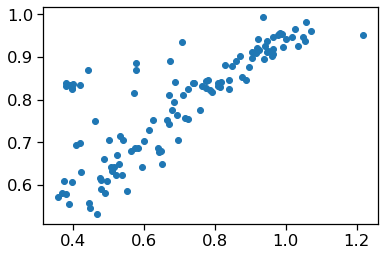

In [102]:
rh1 = rh_from_dewpoint_SP_pt(sp, pt, d2m_interpolated)
rh2 = rh_from_dewpoint_t2m(t2m_interpolated, d2m_interpolated)
plt.scatter(rh1, rh2)

In [103]:
# L13 flux with 2m relative humidity & temp.
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(fluxdf.N2O,fluxdf.U10,fluxdf.SP,fluxdf.pt,slp=fluxdf.msl,
                                          gas='N2O',rh=fluxdf.rh,chi_atm=fluxdf.xN2O_atm,
                                          air_temperature=fluxdf.t2m,
                                         calculate_schmidtair=True, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
Ft1 = Fd+Fc+Fp
Ft1 = Ft1.to('umol/(m2 day)')
fluxdf["Ft1"] = Ft1
fluxdf

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft1
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812,-1.920905
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713,-1.270928
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974,-1.882199
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012,-2.637355
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599,-0.192585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-67.6155,173.5408,34.0405,-0.741753,0.000016,3.295004e-07,0.986837,12.196659,-0.408461,12.203497,-1.431891,-6.638098,0.676284,-2.149681
115,-67.2488,174.4687,34.0408,-0.935808,0.000017,3.294974e-07,0.987382,8.952780,-1.690482,9.110982,-0.943762,-6.701880,0.649304,-1.244914
116,-66.9985,176.8609,34.0227,-0.970711,0.000016,3.294918e-07,0.983479,1.718008,5.024490,5.310089,-2.267645,-5.865057,0.763129,0.338666
117,-66.9992,178.1452,34.0348,-0.562308,0.000016,3.294889e-07,0.985356,2.677869,6.180395,6.735596,-3.350134,-9.827551,0.608244,-0.542321


In [104]:
# L13 flux, assume RH=1 and air temp=surface temp
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(fluxdf.N2O,fluxdf.U10,fluxdf.SP,fluxdf.pt,slp=fluxdf.msl,
                                          gas='N2O',rh=1.0,chi_atm=fluxdf.xN2O_atm,
                                          air_temperature=fluxdf.pt,
                                         calculate_schmidtair=True, return_vars = ["Fd","Fc","Fp","Deq","Ks","Kc","ScW","Geq"])
Ft = Fd+Fc+Fp
Ft = Ft.to('umol/(m2 day)')
fluxdf["Ft"] = Ft
fluxdf

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft1,Ft
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812,-1.920905,-2.046440
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713,-1.270928,-1.350744
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974,-1.882199,-1.990297
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012,-2.637355,-2.757290
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599,-0.192585,-0.341693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-67.6155,173.5408,34.0405,-0.741753,0.000016,3.295004e-07,0.986837,12.196659,-0.408461,12.203497,-1.431891,-6.638098,0.676284,-2.149681,-2.412199
115,-67.2488,174.4687,34.0408,-0.935808,0.000017,3.294974e-07,0.987382,8.952780,-1.690482,9.110982,-0.943762,-6.701880,0.649304,-1.244914,-1.410799
116,-66.9985,176.8609,34.0227,-0.970711,0.000016,3.294918e-07,0.983479,1.718008,5.024490,5.310089,-2.267645,-5.865057,0.763129,0.338666,0.284582
117,-66.9992,178.1452,34.0348,-0.562308,0.000016,3.294889e-07,0.985356,2.677869,6.180395,6.735596,-3.350134,-9.827551,0.608244,-0.542321,-0.661818


In [105]:
pN2O

array([346.02860472, 348.10099161, 348.60123846, 349.53630462,
       324.64333191, 327.6782111 , 340.65722805, 361.57270809,
       356.32457266, 360.05005565, 347.99268964, 358.96745493,
       339.38392922, 339.17512876, 350.48929653, 329.14550037,
       340.19253874, 346.68892449, 348.62965054, 339.14177846,
       355.38557199, 331.2316441 , 370.89114404, 380.15216478,
       348.61182414, 361.90322675, 345.41076456, 353.71982075,
       348.53848387, 377.84762871, 336.34661432, 342.70309878,
       332.84665209, 360.49516056, 356.15161709, 348.49106219,
       373.9875538 , 357.12716345, 356.76296456, 348.50521221,
       340.16435009, 327.66963996, 329.88579689, 327.32936405,
       352.09178156, 326.82114668, 333.05230023, 328.8690362 ,
       337.92268843, 358.52747582, 344.40226335, 343.13785015,
       333.85490376, 339.80934527, 327.72223055, 326.15981919,
       328.19212046, 327.51549278, 328.42936868, 325.68721216,
       328.18310203, 327.80329438, 321.78578586, 322.92

In [106]:
s_mol_L_atm = calculate_s(sp,pt)
Sc = calculate_schmidt(pt)
vp_sw = vpress_sw(fluxdf.SP,pt) # vapor pressure of water
f = fugacity_factor(pt, gas="N2O", slp=msl_interpolated)
pN2O_atm = XN2Oa*(msl_interpolated - vp_sw)*f*1e9
#pN2Oatm(sp,pt,slp=msl_interpolated,xn2o=XN2Oa, units = "natm", v=32.3, watervapor=True, nonideal=True)
dpN2O = (pN2O_atm - pN2O)*1e-9
k_cm_h = calculate_k(U10, Sc)
F_g_m2_year, F_umol_m2_day = calculate_flux(k_cm_h,s_mol_L_atm, dpN2O)
fluxdf["F_umol_m2_day"] = F_umol_m2_day
fluxdf

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft1,Ft,F_umol_m2_day
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812,-1.920905,-2.046440,-1.519102
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713,-1.270928,-1.350744,-0.744358
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974,-1.882199,-1.990297,-1.409350
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012,-2.637355,-2.757290,-2.241150
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599,-0.192585,-0.341693,-0.156106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-67.6155,173.5408,34.0405,-0.741753,0.000016,3.295004e-07,0.986837,12.196659,-0.408461,12.203497,-1.431891,-6.638098,0.676284,-2.149681,-2.412199,-2.084009
115,-67.2488,174.4687,34.0408,-0.935808,0.000017,3.294974e-07,0.987382,8.952780,-1.690482,9.110982,-0.943762,-6.701880,0.649304,-1.244914,-1.410799,-1.012966
116,-66.9985,176.8609,34.0227,-0.970711,0.000016,3.294918e-07,0.983479,1.718008,5.024490,5.310089,-2.267645,-5.865057,0.763129,0.338666,0.284582,0.416485
117,-66.9992,178.1452,34.0348,-0.562308,0.000016,3.294889e-07,0.985356,2.677869,6.180395,6.735596,-3.350134,-9.827551,0.608244,-0.542321,-0.661818,-0.256590


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  1.,  2.,  1.,  3.,  2.,  1.,  0.,  4.,  1.,  1.,
         2.,  5.,  6.,  6.,  6., 11., 12., 11., 15., 15.,  2.,  3.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.]),
 array([-0.44134246, -0.42944162, -0.41754078, -0.40563994, -0.3937391 ,
        -0.38183826, -0.36993742, -0.35803658, -0.34613574, -0.3342349 ,
        -0.32233406, -0.31043321, -0.29853237, -0.28663153, -0.27473069,
        -0.26282985, -0.25092901, -0.23902817, -0.22712733, -0.21522649,
        -0.20332565, -0.19142481, -0.17952396, -0.16762312, -0.15572228,
        -0.14382144, -0.1319206 , -0.12001976, -0.10811892, -0.09621808,
        -0.08431724, -0.0724164 , -0.06051556, -0.04861471, -0.03671387,
        -0.02481303, -0.01291219, -0.00101135,  0.01088949,  0.02279033,
         0.03469117,  0.04659201,  0.05849285,  0.0703937 ,  0.08229454,
         0.09419538,  0.10609622,  0.11799706,  0.1298979 ,

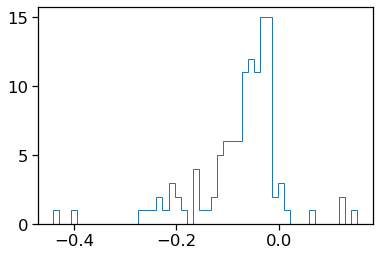

In [107]:
plt.hist(fluxdf.Ft - fluxdf.Ft1, bins = 50, histtype = "step")

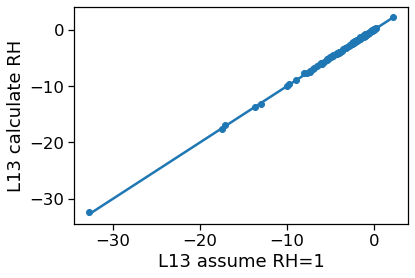

In [108]:
fig, ax = plt.subplots()
ax.scatter(fluxdf.Ft, fluxdf.Ft1)
ax.set_xlabel("L13 assume RH=1")
ax.set_ylabel("L13 calculate RH")
ax.plot(np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()),
        np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()))

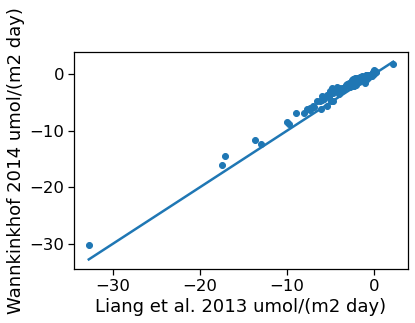

In [109]:
fig, ax = plt.subplots()
ax.scatter(fluxdf.Ft, fluxdf.F_umol_m2_day)
ax.set_ylabel("Wannkinkhof 2014 umol/(m2 day)")
ax.set_xlabel("Liang et al. 2013 umol/(m2 day)")
ax.plot(np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()),
        np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()))

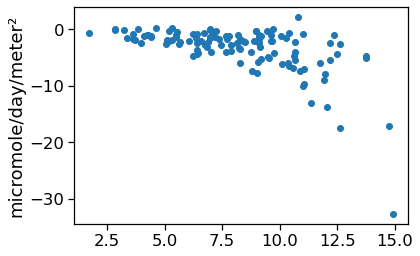

In [110]:
plt.scatter(U10, Ft)

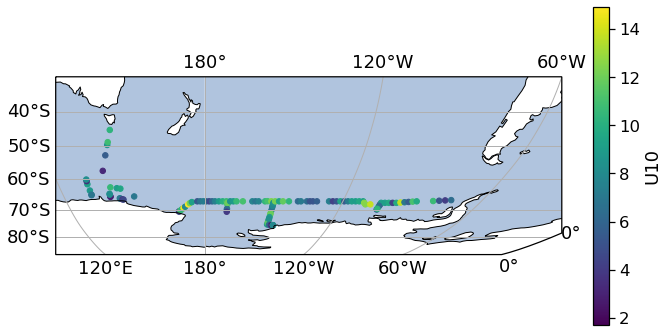

In [112]:
plotdf = fluxdf
fig = plt.figure(figsize=[10, 5]) #figsize=fig dimension (width, height) in inches
#fig = plt.figure(figsize=[20, 10]) #figsize=fig dimension (width, height) in inches
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-180.0))

cax=ax.scatter(x=plotdf.LONGITUDE,y=plotdf.LATITUDE,
               c = U10,
               #edgecolor = colors[count,:3],
               s=30,
           #label = w,
               #norm=pltcolors.PowerNorm(gamma=2),
        transform=ccrs.PlateCarree(),
              cmap = "viridis"
              )

cbar = fig.colorbar(cax).set_label(r'U10')
#cax.set_clim([-75,300])
    
ax.set_extent([-230, -60, -90, -30], ccrs.PlateCarree()) #can adjust these lat/long to change range of map
ax.gridlines(draw_labels=True)
ax.coastlines(color='black',facecolor='gray')
ax.add_feature(cfeature.OCEAN,facecolor='lightsteelblue')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.set_facecolor("k")
plt.tight_layout()
plt.show()

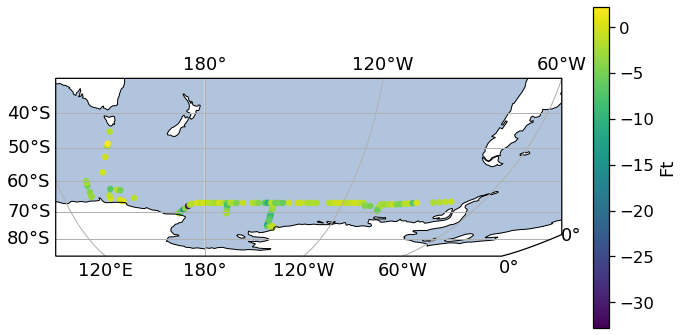

In [113]:
plotdf = fluxdf
fig = plt.figure(figsize=[10, 5]) #figsize=fig dimension (width, height) in inches
#fig = plt.figure(figsize=[20, 10]) #figsize=fig dimension (width, height) in inches
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-180.0))

cax=ax.scatter(x=plotdf.LONGITUDE,y=plotdf.LATITUDE,
               c = plotdf["Ft"],
               #edgecolor = colors[count,:3],
               s=30,
           #label = w,
               #norm=pltcolors.PowerNorm(gamma=2),
        transform=ccrs.PlateCarree(),
              cmap = "viridis"
              )

cbar = fig.colorbar(cax).set_label(r'Ft')
#cax.set_clim([-75,300])
    
ax.set_extent([-230, -60, -90, -30], ccrs.PlateCarree()) #can adjust these lat/long to change range of map
ax.gridlines(draw_labels=True)
ax.coastlines(color='black',facecolor='gray')
ax.add_feature(cfeature.OCEAN,facecolor='lightsteelblue')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.set_facecolor("k")
plt.tight_layout()
plt.show()

In [114]:
fluxdf[fluxdf.Ft == fluxdf.Ft.min()]

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft1,Ft,F_umol_m2_day
113,-68.0116,172.8223,33.94,-0.829278,0.00002,3.295711e-07,0.982301,0.900387,-14.895999,14.923186,2.581171,1.879785,0.951194,-32.344763,-32.786106,-30.244963


In [115]:
fluxdf[fluxdf.msl == fluxdf.msl.min()]

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft1,Ft,F_umol_m2_day
67,-69.7473,-102.9972,33.7738,-1.818187,0.000017,3.293330e-07,0.945944,5.610663,0.271775,5.617241,-5.560217,-6.42771,0.935904,-2.539217,-2.530845,-1.077868


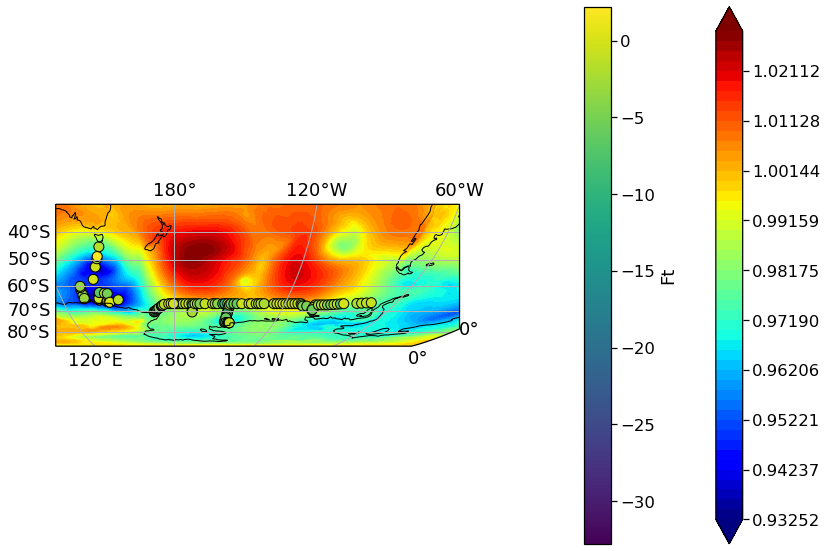

In [116]:
surface = fluxdf

#era = xr.open_dataset("datasets/2017_mean_sea_level_pressure.nc") # local
era21 = xr.open_dataset(f"n2otests/2018_mean_sea_level_pressure.nc") # Poseidon
lon1D = era21['longitude'][:].values
lat1D = era21['latitude'][:].values
time1D = era21['time'][:].values

lon2D, lat2D = np.meshgrid(lat1D, lon1D, indexing='ij')

msl2D = era21.sel(time='2018-03-18 18:00:00').msl
msl2D = msl2D/101325.0 # convert from Pa to atm

msllevs = np.linspace(msl2D.min(),msl2D.max())

fig = plt.figure(figsize=[12, 8]) #figsize=fig dimension (width, height) in inches
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-180))

cmesh = ax.contourf(lat2D, lon2D, msl2D, msllevs, cmap='jet', extend='both',
           transform=ccrs.PlateCarree())

cax = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface["Ft"],
                  #alpha = 0.5,
                  s=100, #marker size
                  edgecolor = 'k',
                  label = None,
                  #norm=colors.PowerNorm(gamma=0.5),
                  transform=ccrs.PlateCarree())

cbar = fig.colorbar(cmesh, location='right')
cbar = fig.colorbar(cax, pad = 0.2).set_label(r'Ft')
#cax.set_clim([0,34])
ax.set_extent([-230, -60, -90, -30], ccrs.PlateCarree()) #can adjust these lat/long to change range of map
ax.gridlines(draw_labels=True)
ax.coastlines(color='black',facecolor='gray')

plt.tight_layout()
plt.show()

In [234]:
fluxdf

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft1,Ft,F_umol_m2_day
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812,-1.920905,-2.046440,-1.519102
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713,-1.270928,-1.350744,-0.744358
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974,-1.882199,-1.990297,-1.409350
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012,-2.637355,-2.757290,-2.241150
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599,-0.192585,-0.341693,-0.156106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-67.6155,173.5408,34.0405,-0.741753,0.000016,3.295004e-07,0.986837,12.196659,-0.408461,12.203497,-1.431891,-6.638098,0.676284,-2.149681,-2.412199,-2.084009
115,-67.2488,174.4687,34.0408,-0.935808,0.000017,3.294974e-07,0.987382,8.952780,-1.690482,9.110982,-0.943762,-6.701880,0.649304,-1.244914,-1.410799,-1.012966
116,-66.9985,176.8609,34.0227,-0.970711,0.000016,3.294918e-07,0.983479,1.718008,5.024490,5.310089,-2.267645,-5.865057,0.763129,0.338666,0.284582,0.416485
117,-66.9992,178.1452,34.0348,-0.562308,0.000016,3.294889e-07,0.985356,2.677869,6.180395,6.735596,-3.350134,-9.827551,0.608244,-0.542321,-0.661818,-0.256590


(array([  1.,   0.,   0.,   0.,   2.,   1.,   0.,   1.,   1.,   4.,   3.,
          3.,   2.,   4.,  12.,   7.,  13.,   7.,  14.,  21.,  17.,  20.,
         29.,  36.,  49.,  35.,  57.,  69.,  64.,  83.,  73.,  91., 119.,
        112., 133., 164., 150., 160., 209., 223., 246., 228., 251., 292.,
        273., 289., 280., 294., 307., 275., 318., 311., 318., 323., 282.,
        260., 273., 261., 266., 269., 242., 228., 208., 166., 184., 157.,
        145., 128.,  95., 106., 114.,  84.,  74.,  58.,  65.,  47.,  50.,
         42.,  43.,  33.,  30.,  18.,  12.,  13.,   7.,  12.,   6.,   3.,
          4.,   3.,   4.,   1.,   4.,   0.,   2.,   2.,   1.,   2.,   1.,
          1.]),
 array([-0.17986452, -0.1690213 , -0.15817808, -0.14733486, -0.13649164,
        -0.12564843, -0.11480521, -0.10396199, -0.09311877, -0.08227556,
        -0.07143234, -0.06058912, -0.0497459 , -0.03890268, -0.02805947,
        -0.01721625, -0.00637303,  0.00447019,  0.0153134 ,  0.02615662,
         0.03699984,  0.04

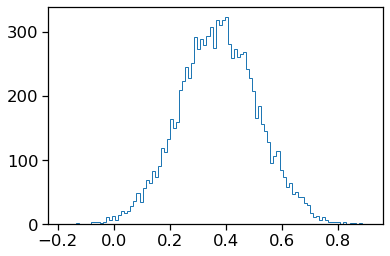

In [111]:
iters = 10000
mu, sigma = 0.37, 0.14
s = np.random.normal(mu, sigma, iters)


fig, ax = plt.subplots()
ax.hist(s, bins=100, histtype="step")

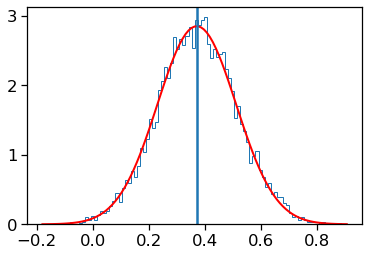

In [112]:
percents = np.random.normal(1, 0.14/0.37, iters)
s2 = percents*mu
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(s, 100, density=True, histtype="step")
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
ax.axvline(mu)

In [113]:
percents = np.random.normal(1, 0.01, (len(surface),iters))
sp = np.array([surface.CTDSAL]).T
spmc = sp*percents
spmc[:,0].shape

(119,)

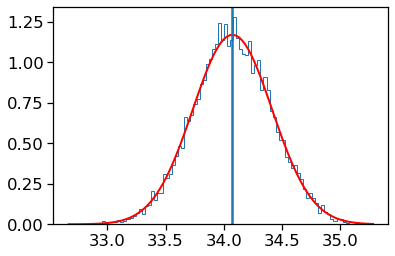

In [114]:
sigma = 0.01*sp[0]
mu = sp[0]
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(spmc[0,:], 100, density=True, histtype="step")
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
ax.axvline(sp[0])

In [115]:
# generate a m×n numpy array of random values where each value is either 1 or drawn from a normal distribution with mean 
# μ and standard deviation σ:
def random_beta(mu, sigma, p, m, n):
    """
    Generate an m x n array of random variables that are either 1 or values from a normal distribution.
    
    Parameters:
    mu (float): Mean of the normal distribution.
    sigma (float): Standard deviation of the normal distribution.
    p (float): Probability of the random variable being 1.
    m (int): Number of rows in the output array.
    n (int): Number of columns in the output array.
    
    Returns:
    numpy.ndarray: An m x n array of random variables.
    """
    # Generate an m x n array of random values between 0 and 1
    random_values = np.random.rand(m, n)
    
    # Generate an m x n array from a normal distribution
    normal_values = np.random.normal(mu, sigma, (m, n))
    
    # Use a condition to select either 1 or the normal value
    result = np.where(random_values < p, 1, normal_values)
    
    return result

# Example usage
mu = 5
sigma = 2
p = 0.5  # Probability of the variable being 1
m = 3  # Number of rows
n = 4  # Number of columns

# Generate the random variable array
random_vars_array = random_beta(mu, sigma, p, m, n)
print(random_vars_array)

[[ 6.71586672  4.64452053  1.          1.        ]
 [ 8.12750538  2.94028247  1.          6.5229542 ]
 [ 5.95854157  4.10110609 10.72821477  1.        ]]


(array([8.50269751e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.50269751e-03,
        8.50269751e-03, 2.55080925e-02, 1.70053950e-02, 1.70053950e-02,
        1.70053950e-02, 2.55080925e-02, 5.10161851e-02, 3.40107900e-02,
        8.50269751e-02, 5.10161851e-02, 5.10161851e-02, 9.35296726e-02,
        1.10535068e-01, 1.10535068e-01, 1.70053950e-01, 2.38075530e-01,
        2.72086320e-01, 1.95562043e-01, 3.14599808e-01, 3.40107900e-01,
        4.25134876e-01, 4.84653758e-01, 6.29199616e-01, 5.52675338e-01,
        6.97221196e-01, 8.92783239e-01, 8.41767054e-01, 9.43799424e-01,
        8.41767054e-01, 1.02032370e+00, 1.08834528e+00, 1.36043160e+00,
        1.18187495e+00, 1.08834528e+00, 1.28390732e+00, 1.31791811e+00,
        1.38593969e+00, 1.27540463e+00, 1.54749095e+00, 1.39444239e+00,
        1.38593969e+00, 1.42845318e+00, 1.30941542e+00, 1.50497746e+00,
        1.08834528e+00, 1.17337226e+00, 1.13085877e+00, 1.164869

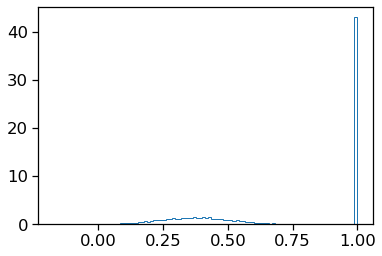

In [116]:
beta = random_beta(0.37, 0.14, 0.5, len(surface), iters)
plt.hist(beta[0,:], 100, density=True, histtype="step")

In [117]:
surface.pN2O

0       346.028605
26      348.100992
38      348.601238
63      349.536305
79      324.643332
           ...    
3958    330.834051
3984    329.864313
4022    311.164440
4034    324.929478
4060    322.200567
Name: pN2O, Length: 119, dtype: float64

In [118]:
surface.columns

Index(['Unnamed: 0', 'LONGITUDE', 'LATITUDE', 'YEAR', 'EXPOCODE', 'woce_lines',
       'startDate', 'endDate', 'source', 'SECT_ID', 'STNNBR', 'CASTNO',
       'BTLNBR', 'SAMPNO', 'DATE', 'TIME', 'DEPTH', 'CTDPRS', 'CTDPRS_FLAG_W',
       'CTDTMP', 'CTDTMP_FLAG_W', 'CTDSAL', 'CTDSAL_FLAG_W', 'SALNTY',
       'SALNTY_FLAG_W', 'CTDOXY', 'CTDOXY_FLAG_W', 'NITRAT', 'NITRAT_FLAG_W',
       'N2O', 'N2O_FLAG_W', 'SA', 'PT', 'CT', 'rho', 'sigma0', 'O2sat',
       'spiciness', 'AOU', 'N2O_nM', 'N2Osol', 'pN2O', 'DN2O', 'BIOME_NUM',
       'BIOME_ABREV', 'BIOME_FULL', 'date', 'hour', 'minute', 'datetime', 't',
       'timedelta', 'n2o_atm', 'timedeltaERA'],
      dtype='object')

In [119]:
# calculate wind-dependent terms
# these will get used as mean values for the Monte Carlo arrays
Ks, Kb, Kc, dP = L13(surface.pN2O*1e-9,
                     np.array(np.sqrt(u10_interpolated**2 + v10_interpolated**2)),
                     surface.CTDSAL,surface.PT,slp=msl_interpolated,
                     gas='N2O',rh=1.0,chi_atm=surface.n2o_atm*1e-9,
                     air_temperature=surface.PT, calculate_schmidtair=True,
                     return_vars = ["Ks", "Kb", "Kc", "dP"],
                     pressure_mode=True)

Ks.shape

(119,)

In [137]:
# set up monte carlo arrays
# reshape K terms from (len(surface),) to (len(surface),1) to make them broadcastable to (len(surface),iters)
Kserror = np.random.normal(1, 0.15, (len(surface),iters))
Kserror = np.array([Ks]).T*Kserror

Kberror = np.random.normal(1, 0.3, (len(surface),iters))
Kberror = np.array([Kb]).T*Kberror

Kcerror = np.random.normal(1, 0.3, (len(surface),iters))
Kcerror = np.array([Kc]).T*Kcerror

dPerror = np.random.normal(1, 0.3, (len(surface),iters))
dPerror = np.array([dP]).T*dPerror

# set up u10 array as a placeholder
# U10 won't actually get used in the calculations because we're imposing k-values and dP
u10 = np.sqrt(u10_interpolated**2 + v10_interpolated**2).reshape(-1, 1)
u10error = np.tile(u10[:], (1, iters))

# other terms
mslerror = np.random.normal(1, 0.01, (len(surface),iters))
msl = np.array([surface.msl]).T*mslerror
sperror = np.random.normal(1, 0.01, (len(surface),iters))
sp = np.array([surface.CTDSAL]).T*sperror
pterror = np.random.normal(1, 0.01, (len(surface),iters))
pt = np.array([surface.PT]).T*pterror
pN2Oerror = np.random.normal(1, 0.01, (len(surface),iters))
pN2O = np.array([surface.pN2O*1e-9]).T*pN2Oerror
n2o_atmerror = np.random.normal(1, 0.01, (len(surface),iters))
n2o_atm = np.array([surface.n2o_atm*1e-9]).T*n2o_atmerror
Cerror = np.random.normal(1, 0.01, (len(surface),iters))
C = np.array([surface.N2O_nM*1e-6]).T*Cerror

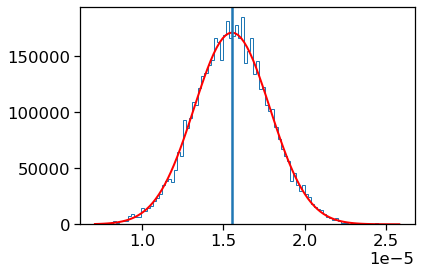

In [135]:
Kserror = np.random.normal(1, 0.15, (len(surface),iters))
Kserror = np.array([Ks]).T*Kserror

mu = np.mean(Kserror[0,:])
sigma = np.std(Kserror[0,:])
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(Kserror[0,:], 100, density=True, histtype="step")
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
ax.axvline(mu)

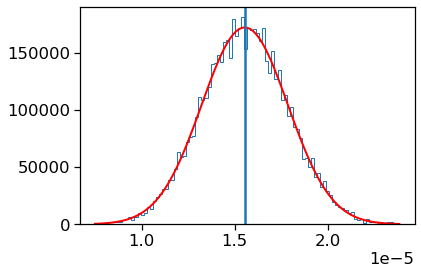

In [136]:
Ks_reshaped = np.array(Ks).reshape(-1, 1)
Kserror = np.random.normal(loc=Ks_reshaped, scale=0.15 * Ks_reshaped, size=(len(surface),iters))

mu = np.mean(Kserror[0,:])
sigma = np.std(Kserror[0,:])
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(Kserror[0,:], 100, density=True, histtype="step")
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
ax.axvline(mu)

In [138]:
# calculate flux from monte carlo arrays
Fd,Fc,Fp,dP,Ks,Kb,Kc = L13(pN2O,u10error,sp,pt,slp=1.0,gas='N2O',rh=1.0,chi_atm=n2o_atm,
                                 air_temperature=pt, calculate_schmidtair=True,
                                 Ks = Kserror, Kb = Kberror, Kc = Kcerror, dP = dPerror,
    return_vars = ["Fd","Fc","Fp","dP","Ks","Kb", "Kc"],
    beta = beta, pressure_mode=True)

F = (1-output.siconc)*(Fd+Fc+Fp)*86400*1e6

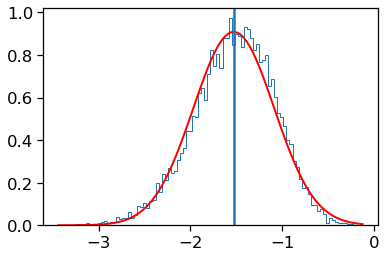

In [139]:
mu = np.mean(F[0,:])
sigma = np.std(F[0,:])
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(F[0,:], 100, density=True, histtype="step")
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
ax.axvline(mu)

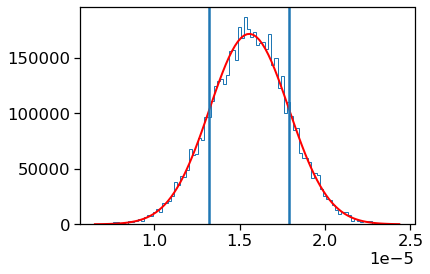

In [140]:
mu = np.mean(Kserror[0,:])
sigma = np.std(Kserror[0,:])
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(Kserror[0,:], 100, density=True, histtype="step")
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
ax.axvline(mu - 0.15*mu)
ax.axvline(mu + 0.15*mu)

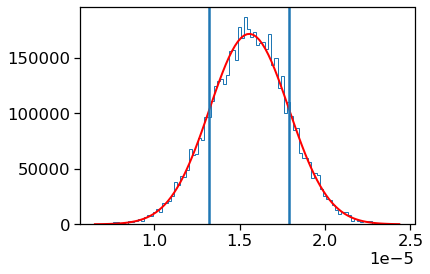

In [141]:
mu = np.mean(Ks[0,:])
sigma = np.std(Ks[0,:])
fig, ax = plt.subplots()
count, bins, ignored = ax.hist(Ks[0,:], 100, density=True, histtype="step")
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
ax.axvline(mu - 0.15*mu)
ax.axvline(mu + 0.15*mu)

<ErrorbarContainer object of 3 artists>

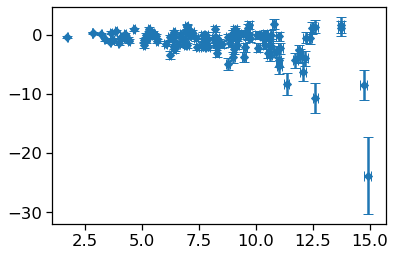

In [142]:
fig, ax = plt.subplots()
ax.errorbar(np.mean(U10, axis=1), np.mean(F, axis=1),
            xerr = np.std(U10, axis=1), yerr = np.std(F, axis=1),
           linestyle = "none", marker = "D", capsize = 5)